In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time

from sklearn.model_selection import train_test_split # We'll use this for splitting cycles now
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define directories
PROCESSED_DATA_DIR = '../data/processed_data/'
MODEL_DIR = '../models/'
VISUALIZATION_DIR = '../visualizations/'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(VISUALIZATION_DIR, exist_ok=True) # Make sure viz dir exists for this notebook too

# --- Configuration ---
BATTERY_ID_TO_PROCESS = 'B0005' # Start with B0005
TARGET_VARIABLE = 'soh'       # We are predicting SoH

# --- Load Data for the Specific Battery ---
print(f"Loading preprocessed data for battery: {BATTERY_ID_TO_PROCESS}")
csv_filename = f'nasa_battery_data_{BATTERY_ID_TO_PROCESS}_preprocessed.csv'
csv_filepath = os.path.join(PROCESSED_DATA_DIR, csv_filename)

try:
    df_battery = pd.read_csv(csv_filepath)
    print(f"Successfully loaded {csv_filename}. Shape: {df_battery.shape}")
    df_battery.info()
except FileNotFoundError:
    print(f"Error: File not found at {csv_filepath}")
    df_battery = None
except Exception as e:
    print(f"Error loading CSV: {e}")
    df_battery = None

# Set plot style
sns.set_theme(style="whitegrid")

Loading preprocessed data for battery: B0005
Successfully loaded nasa_battery_data_B0005_preprocessed.csv. Shape: (591458, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591458 entries, 0 to 591457
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   battery_id                   591458 non-null  object 
 1   cycle_number                 591458 non-null  int64  
 2   cycle_type                   591458 non-null  object 
 3   ambient_temperature          591458 non-null  int64  
 4   measurement_time_relative    591458 non-null  float64
 5   voltage_measured             591458 non-null  float64
 6   current_measured             591458 non-null  float64
 7   temperature_measured         591458 non-null  float64
 8   voltage_load_or_charge       591458 non-null  float64
 9   current_load_or_charge       591458 non-null  float64
 10  capacity                     50285 non-null   flo

## Split Data (Chronological by Cycle for this Battery)

In [2]:
if df_battery is not None:
    print(f"\nSplitting data for {BATTERY_ID_TO_PROCESS}...")

    # Get unique cycle numbers sorted
    unique_cycles = np.sort(df_battery['cycle_number'].unique())
    n_cycles = len(unique_cycles)
    print(f" Total unique cycles: {n_cycles}")

    if n_cycles < 3:
        print(f" Not enough cycles to split {BATTERY_ID_TO_PROCESS}. Skipping further steps.")
        # Handle error or exit
    else:
        # Define split points based on cycle numbers
        train_split_ratio = 0.70
        val_split_ratio = 0.15

        train_end_cycle = unique_cycles[int(n_cycles * train_split_ratio) - 1]
        val_end_cycle = unique_cycles[int(n_cycles * (train_split_ratio + val_split_ratio)) - 1]

        print(f"  Train cycles: Up to {train_end_cycle}")
        print(f"  Validation cycles: {train_end_cycle + 1} to {val_end_cycle}")
        print(f"  Test cycles: From {val_end_cycle + 1}")

        # Create masks
        train_mask = df_battery['cycle_number'] <= train_end_cycle
        val_mask = (df_battery['cycle_number'] > train_end_cycle) & (df_battery['cycle_number'] <= val_end_cycle)
        test_mask = df_battery['cycle_number'] > val_end_cycle

        # Apply masks
        df_train = df_battery[train_mask].copy()
        df_val = df_battery[val_mask].copy()
        df_test = df_battery[test_mask].copy()

        print(f"\n  Train set shape: {df_train.shape}")
        print(f"  Validation set shape: {df_val.shape}")
        print(f"  Test set shape: {df_test.shape}")

        # Verify split ranges
        if not df_train.empty: print(f"  Train cycles range: {df_train['cycle_number'].min()} - {df_train['cycle_number'].max()}")
        if not df_val.empty: print(f"  Val cycles range:   {df_val['cycle_number'].min()} - {df_val['cycle_number'].max()}")
        if not df_test.empty: print(f"  Test cycles range:  {df_test['cycle_number'].min()} - {df_test['cycle_number'].max()}")

else:
    print("Cannot split data, DataFrame not loaded.")


Splitting data for B0005...
 Total unique cycles: 338
  Train cycles: Up to 421
  Validation cycles: 422 to 517
  Test cycles: From 518

  Train set shape: (389524, 18)
  Validation set shape: (102228, 18)
  Test set shape: (99706, 18)
  Train cycles range: 1 - 421
  Val cycles range:   423 - 517
  Test cycles range:  519 - 616


## Prepare Features and Target for SoH Prediction

In [3]:
if 'df_train' in locals(): # Check if split was successful
    print(f"\nPreparing Features (X) and Target (y={TARGET_VARIABLE}) for {BATTERY_ID_TO_PROCESS}...")

    # Define Features
    feature_cols = [
        'cycle_number',
        'ambient_temperature',
        'measurement_time_relative',
        'voltage_measured_smooth',
        'current_measured_smooth',
        'temperature_measured_smooth',
        'voltage_load_or_charge',
        'current_load_or_charge',
        'discharge_time_s',       # Will have NaNs in charge cycles
        'delta_temp_measured'     # Will have NaNs in charge cycles
    ]
    numerical_features = df_train[feature_cols].select_dtypes(include=np.number).columns.tolist()
    print(f" Using features: {feature_cols}")

    # --- Filter for Target Availability (Keep only discharge cycles for SoH) ---
    print(f" Filtering data where target '{TARGET_VARIABLE}' is not NaN...")
    df_train_filtered = df_train.dropna(subset=[TARGET_VARIABLE]).copy()
    df_val_filtered = df_val.dropna(subset=[TARGET_VARIABLE]).copy()
    df_test_filtered = df_test.dropna(subset=[TARGET_VARIABLE]).copy()

    print(f"  Train shape after filtering: {df_train_filtered.shape}")
    print(f"  Val shape after filtering:   {df_val_filtered.shape}")
    print(f"  Test shape after filtering:  {df_test_filtered.shape}")

    if df_train_filtered.empty:
        print(" Error: No data left after filtering for target. Cannot proceed.")
        # Handle error
    else:
        # --- Separate X and y ---
        X_train = df_train_filtered[feature_cols]
        y_train = df_train_filtered[TARGET_VARIABLE]
        X_val = df_val_filtered[feature_cols]
        y_val = df_val_filtered[TARGET_VARIABLE]
        X_test = df_test_filtered[feature_cols]
        y_test = df_test_filtered[TARGET_VARIABLE]

        # --- Impute NaNs in Features ---
        # (Cycle summary features are NaN for non-discharge cycles, but we filtered those rows out)
        # Double check if any NaNs remain in features *after* filtering for target
        print(f"\n Checking for NaNs in features after filtering...")
        print(" X_train NaNs:\n", X_train.isnull().sum()[X_train.isnull().sum() > 0])
        # If NaNs appear here, it means they were present *within* discharge cycles,
        # need to decide on imputation strategy (mean, median, 0 etc.)
        # Assuming no NaNs remain based on previous steps, but adding imputer just in case

        imputer = SimpleImputer(strategy='mean') # Use mean for any remaining numerical NaNs
        # Fit only on training numerical data
        imputer.fit(X_train[numerical_features])
        # Transform all sets
        X_train[numerical_features] = imputer.transform(X_train[numerical_features])
        if not X_val.empty: X_val[numerical_features] = imputer.transform(X_val[numerical_features])
        if not X_test.empty: X_test[numerical_features] = imputer.transform(X_test[numerical_features])
        print(" Applied imputer (mean strategy) just in case.")


        # --- Scale Features ---
        print("\n Scaling numerical features...")
        scaler = StandardScaler()
        # Fit only on training numerical data
        scaler.fit(X_train[numerical_features])
        # Transform all sets
        X_train[numerical_features] = scaler.transform(X_train[numerical_features])
        if not X_val.empty: X_val[numerical_features] = scaler.transform(X_val[numerical_features])
        if not X_test.empty: X_test[numerical_features] = scaler.transform(X_test[numerical_features])
        print(" Scaling complete.")

        # --- Save Scaler and Imputer for this battery ---
        scaler_filename = os.path.join(MODEL_DIR, f'scaler_{BATTERY_ID_TO_PROCESS}_soh.pkl')
        imputer_filename = os.path.join(MODEL_DIR, f'imputer_{BATTERY_ID_TO_PROCESS}_soh.pkl')
        try:
            with open(scaler_filename, 'wb') as f: pickle.dump(scaler, f)
            with open(imputer_filename, 'wb') as f: pickle.dump(imputer, f)
            print(f" Saved scaler to {scaler_filename}")
            print(f" Saved imputer to {imputer_filename}")
        except Exception as e:
            print(f" Error saving scaler/imputer: {e}")


        print("\n Prepared data shapes:")
        print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"  X_val:   {X_val.shape}, y_val:   {y_val.shape}")
        print(f"  X_test:  {X_test.shape}, y_test:  {y_test.shape}")

else:
    print("Cannot prepare features, data splits not found.")


Preparing Features (X) and Target (y=soh) for B0005...
 Using features: ['cycle_number', 'ambient_temperature', 'measurement_time_relative', 'voltage_measured_smooth', 'current_measured_smooth', 'temperature_measured_smooth', 'voltage_load_or_charge', 'current_load_or_charge', 'discharge_time_s', 'delta_temp_measured']
 Filtering data where target 'soh' is not NaN...
  Train shape after filtering: (34752, 18)
  Val shape after filtering:   (8023, 18)
  Test shape after filtering:  (7510, 18)

 Checking for NaNs in features after filtering...
 X_train NaNs:
 Series([], dtype: int64)
 Applied imputer (mean strategy) just in case.

 Scaling numerical features...
 Scaling complete.
 Saved scaler to ../models/scaler_B0005_soh.pkl
 Saved imputer to ../models/imputer_B0005_soh.pkl

 Prepared data shapes:
  X_train: (34752, 10), y_train: (34752,)
  X_val:   (8023, 10), y_val:   (8023,)
  X_test:  (7510, 10), y_test:  (7510,)


/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_83767/2416061552.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_features] = imputer.transform(X_train[numerical_features])
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_83767/2416061552.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if not X_val.empty: X_val[numerical_features] = imputer.transform(X_val[numerical_features])
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_83767/2416061552.py:59: S

## Train and Evaluate Baseline Random Forest


Training Random Forest Regressor for B0005...
 Training complete in 1.81 seconds.

 Evaluating on Validation Set...
  Validation MAE:  0.0193
  Validation RMSE: 0.0227
  Validation R2:   -1.3613
  OOB Score (R2):  1.0000


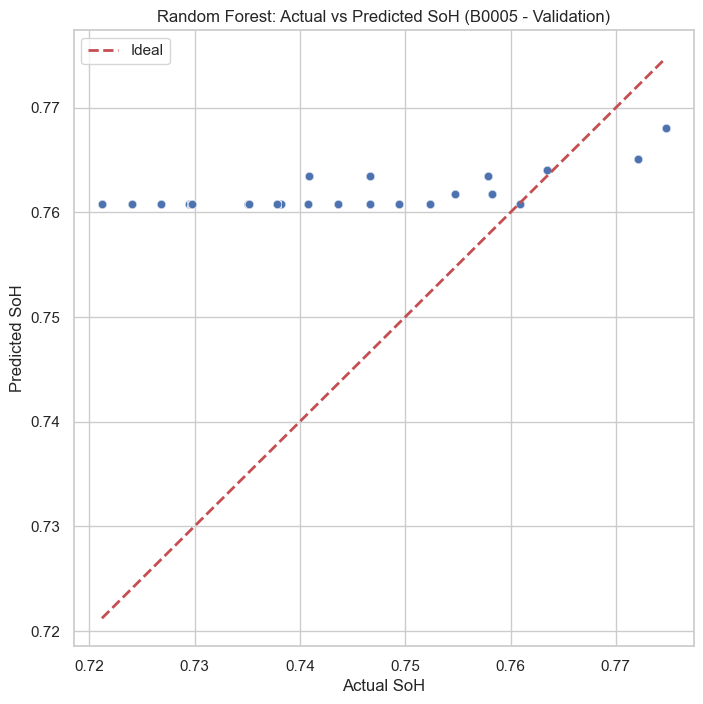


 Feature Importances:


,Feature,Importance
8,discharge_time_s,9.613229e-01
0,cycle_number,3.715592e-02
9,delta_temp_measured,1.516958e-03
7,current_load_or_charge,4.214590e-06
3,voltage_measured_smooth,1.703866e-13
4,current_measured_smooth,1.581245e-13
2,measurement_time_relative,1.522139e-13
5,temperature_measured_smooth,1.493200e-13
6,voltage_load_or_charge,1.357783e-13
1,ambient_temperature,0.000000e+00


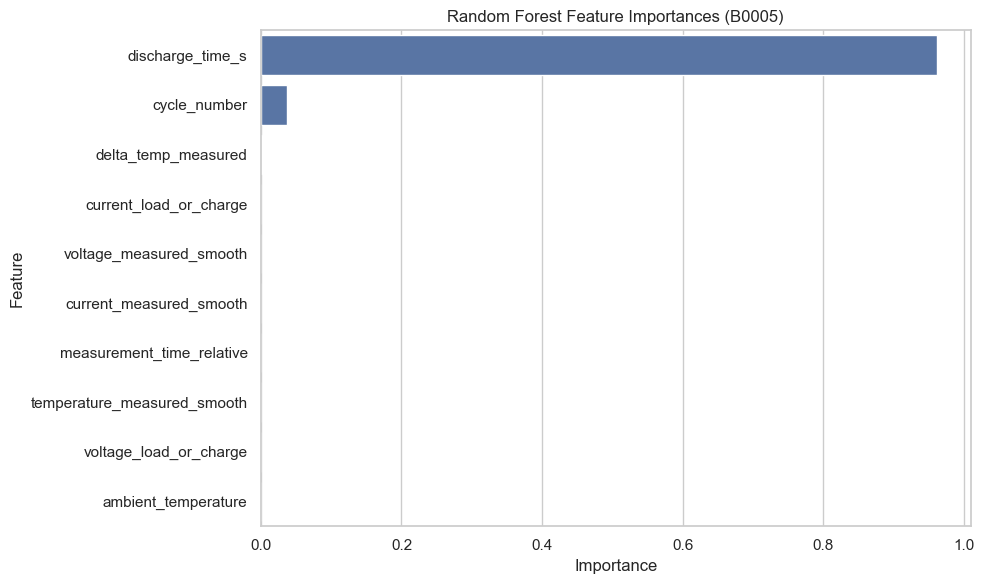


 Saving model to ../models/random_forest_B0005_soh_v1.pkl...
  Model saved.


In [4]:
if 'X_train' in locals() and not X_train.empty: # Check if data preparation was successful
    print(f"\nTraining Random Forest Regressor for {BATTERY_ID_TO_PROCESS}...")

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42,
        oob_score=True
    )

    start_time = time.time()
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    print(f" Training complete in {end_time - start_time:.2f} seconds.")

    # --- Evaluate ---
    print("\n Evaluating on Validation Set...")
    if not X_val.empty:
        y_pred_val = rf_model.predict(X_val)

        mae_val = mean_absolute_error(y_val, y_pred_val)
        mse_val = mean_squared_error(y_val, y_pred_val)
        rmse_val = np.sqrt(mse_val) # Take square root of MSE
        r2_val = r2_score(y_val, y_pred_val)
        oob_score = rf_model.oob_score_

        print(f"  Validation MAE:  {mae_val:.4f}")
        print(f"  Validation RMSE: {rmse_val:.4f}")
        print(f"  Validation R2:   {r2_val:.4f}")
        print(f"  OOB Score (R2):  {oob_score:.4f}") # Estimate on training data

        # --- Visualize ---
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.5)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2, label='Ideal')
        plt.title(f'Random Forest: Actual vs Predicted SoH ({BATTERY_ID_TO_PROCESS} - Validation)')
        plt.xlabel('Actual SoH')
        plt.ylabel('Predicted SoH')
        plt.legend()
        plt.grid(True)
        val_pred_filename = os.path.join(VISUALIZATION_DIR, f'rf_baseline_val_pred_{BATTERY_ID_TO_PROCESS}.png')
        plt.savefig(val_pred_filename)
        plt.show()

    else:
        print("  Validation set is empty, skipping evaluation plots.")

    # --- Feature Importances ---
    print("\n Feature Importances:")
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    display(feature_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Random Forest Feature Importances ({BATTERY_ID_TO_PROCESS})')
    plt.tight_layout()
    feature_imp_filename = os.path.join(VISUALIZATION_DIR, f'rf_baseline_feat_imp_{BATTERY_ID_TO_PROCESS}.png')
    plt.savefig(feature_imp_filename)
    plt.show()

    # --- Save the Model ---
    model_filename = os.path.join(MODEL_DIR, f'random_forest_{BATTERY_ID_TO_PROCESS}_soh_v1.pkl')
    print(f"\n Saving model to {model_filename}...")
    try:
        with open(model_filename, 'wb') as f: pickle.dump(rf_model, f)
        print("  Model saved.")
    except Exception as e:
        print(f"  Error saving model: {e}")

else:
    print("\nCannot train model, prepared training data not found.")

**Evaluation Metrics:**

*   **MAE: 0.0193:** On average, the model's prediction is off by about 1.93% SoH on the validation set. This is a reasonably good start for a baseline.
*   **RMSE: 0.0227:** The root mean squared error is slightly higher than MAE, indicating some predictions might have larger errors. Still, an RMSE of ~2.3% SoH is decent.
*   **R2: -1.3613:** This is problematic! An R2 score of -1.36 is very poor. R2 represents the proportion of variance explained; 1.0 is perfect, 0.0 means the model is no better than predicting the mean, and a *negative* R2 means the model is performing *worse* than just predicting the mean SoH of the validation set. This suggests the model is not generalizing well to the unseen validation cycles.
*   **OOB Score (R2): 1.0000:** This is suspiciously perfect. The OOB score is an estimate of R2 using data points *not* included in each tree's bootstrap sample during training. A perfect OOB score often indicates **overfitting** or an issue with how the data is structured relative to the target.

**Actual vs. Predicted Plot:**

*   This plot visually confirms the poor R2 score. The points are *not* clustered along the ideal diagonal line.
*   Instead, the predictions (Y-axis) seem clustered horizontally around specific values (mostly ~0.76), while the actual values (X-axis) vary between ~0.72 and ~0.775.
*   This indicates the model is struggling to capture the variation in SoH within the validation set; it's often predicting a similar value regardless of the true SoH in that range.

**Feature Importances:**

*   **`discharge_time_s` Dominates:** This feature has an importance of ~0.96, vastly outweighing everything else. The model is almost *exclusively* relying on the total discharge time.
*   **`cycle_number` Second:** Cycle number has a small importance (~0.037).
*   **Other Features Negligible:** Temperature delta, current, voltage, etc., have virtually zero importance according to this model fit.

**Interpretation and Potential Issues:**

1.  **Data Redundancy / Leakage?** The model has learned an almost perfect mapping during training (OOB Score ~1.0) but fails badly on validation (R2 < 0). This classic overfitting pattern is often exacerbated if the training data contains features that inadvertently leak information about the target *within the same cycle*.
    *   In our case, `soh`, `discharge_time_s`, and `delta_temp_measured` are *constant* for all measurement rows within a given discharge cycle. The Random Forest is trained on *all* these individual measurement rows. It might be learning that "if `discharge_time_s` is X, then `soh` is Y" very easily, possibly using subtle variations across the many rows of a single cycle. This doesn't generalize well when it sees cycles in the validation set with slightly different `discharge_time_s` values.
    *   The features like `voltage_measured_smooth`, `current_measured_smooth`, `measurement_time_relative` vary *within* a cycle. The model seems to be ignoring this intra-cycle information almost entirely, focusing only on the cycle-level summary features (`discharge_time_s`).
2.  **Over-reliance on Discharge Time:** While discharge time is correlated with SoH, relying *only* on it makes the model brittle.
3.  **Hyperparameters:** The default hyperparameters might not be optimal, contributing to overfitting.


## Prepare Features and Target for SoH Prediction (CYCLE LEVEL)

In [5]:
if 'df_train' in locals(): # Check if split was successful
    print(f"\nPreparing Features (X) and Target (y={TARGET_VARIABLE}) for {BATTERY_ID_TO_PROCESS} (CYCLE LEVEL)...")

    # --- Aggregate data to cycle level ---
    def aggregate_cycle_data(df_split):
        if df_split.empty:
            return pd.DataFrame() # Return empty if split is empty

        # Filter for discharge cycles only, as SoH is defined for them
        df_discharge = df_split[df_split['cycle_type'] == 'discharge'].copy()
        if df_discharge.empty:
             return pd.DataFrame()

        cycle_agg = df_discharge.groupby(['battery_id', 'cycle_number']).agg(
            soh=('soh', 'first'), # Target
            # --- Potential Features ---
            # Basic cycle info
            ambient_temperature=('ambient_temperature', 'first'),
            # Voltage features
            avg_voltage_measured=('voltage_measured_smooth', 'mean'),
            min_voltage_measured=('voltage_measured_smooth', 'min'),
            # Current features
            avg_current_measured=('current_measured_smooth', 'mean'),
            # Temperature features
            avg_temp_measured=('temperature_measured_smooth', 'mean'),
            max_temp_measured=('temperature_measured_smooth', 'max'),
            delta_temp_measured=('temperature_measured_smooth', lambda x: x.max() - x.min()),
            # Time features
            discharge_time_s=('measurement_time_relative', 'max'),
            # Add variance, skewness etc. if desired later
            # var_voltage_measured=('voltage_measured_smooth', 'var'),
        ).reset_index()
        return cycle_agg

    df_train_cycle = aggregate_cycle_data(df_train)
    df_val_cycle = aggregate_cycle_data(df_val)
    df_test_cycle = aggregate_cycle_data(df_test)

    print(f"  Train shape (cycle level): {df_train_cycle.shape}")
    print(f"  Val shape (cycle level):   {df_val_cycle.shape}")
    print(f"  Test shape (cycle level):  {df_test_cycle.shape}")

    if df_train_cycle.empty or df_val_cycle.empty: # Need train and val for modeling
        print(" Error: Not enough discharge cycle data in train/val splits after aggregation.")
        # Handle error
    else:
        # --- Define Features and Target ---
        target_col = 'soh'
        # Use aggregated features (exclude battery_id for now, maybe soh itself if it was calculated wrongly)
        feature_cols = [col for col in df_train_cycle.columns if col not in ['battery_id', target_col]]
        numerical_features = df_train_cycle[feature_cols].select_dtypes(include=np.number).columns.tolist()

        print(f"\n Using features: {feature_cols}")
        print(f" Using target: {target_col}")

        # --- Separate X and y ---
        X_train = df_train_cycle[feature_cols]
        y_train = df_train_cycle[target_col]
        X_val = df_val_cycle[feature_cols]
        y_val = df_val_cycle[target_col]
        # Handle potentially empty test set after aggregation
        if not df_test_cycle.empty:
            X_test = df_test_cycle[feature_cols]
            y_test = df_test_cycle[target_col]
        else:
            X_test, y_test = pd.DataFrame(), pd.Series() # Empty


        # --- Impute and Scale Features ---
        # Check for NaNs (less likely at cycle level unless aggregation failed)
        print(f"\n Checking for NaNs in aggregated features...")
        print(" X_train NaNs:\n", X_train.isnull().sum()[X_train.isnull().sum() > 0])

        # Use mean imputation for any remaining NaNs (e.g., if variance is NaN for single-point cycles)
        imputer = SimpleImputer(strategy='mean')
        imputer.fit(X_train[numerical_features])
        X_train[numerical_features] = imputer.transform(X_train[numerical_features])
        if not X_val.empty: X_val[numerical_features] = imputer.transform(X_val[numerical_features])
        if not X_test.empty: X_test[numerical_features] = imputer.transform(X_test[numerical_features])
        print(" Applied imputer (mean strategy).")

        # Scale Features
        scaler = StandardScaler()
        scaler.fit(X_train[numerical_features])
        X_train[numerical_features] = scaler.transform(X_train[numerical_features])
        if not X_val.empty: X_val[numerical_features] = scaler.transform(X_val[numerical_features])
        if not X_test.empty: X_test[numerical_features] = scaler.transform(X_test[numerical_features])
        print(" Scaling complete.")

        # --- Save Scaler and Imputer ---
        # Overwrite previous ones or use different names if needed
        scaler_filename = os.path.join(MODEL_DIR, f'scaler_{BATTERY_ID_TO_PROCESS}_soh_cycle.pkl')
        imputer_filename = os.path.join(MODEL_DIR, f'imputer_{BATTERY_ID_TO_PROCESS}_soh_cycle.pkl')
        try:
            with open(scaler_filename, 'wb') as f: pickle.dump(scaler, f)
            with open(imputer_filename, 'wb') as f: pickle.dump(imputer, f)
            print(f" Saved cycle-level scaler to {scaler_filename}")
            print(f" Saved cycle-level imputer to {imputer_filename}")
        except Exception as e:
            print(f" Error saving scaler/imputer: {e}")

        print("\n Prepared cycle-level data shapes:")
        print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"  X_val:   {X_val.shape}, y_val:   {y_val.shape}")
        print(f"  X_test:  {X_test.shape}, y_test:  {y_test.shape if not y_test.empty else 0}")

else:
    print("Cannot prepare features, data splits not found.")


Preparing Features (X) and Target (y=soh) for B0005 (CYCLE LEVEL)...
  Train shape (cycle level): (117, 11)
  Val shape (cycle level):   (26, 11)
  Test shape (cycle level):  (25, 11)

 Using features: ['cycle_number', 'ambient_temperature', 'avg_voltage_measured', 'min_voltage_measured', 'avg_current_measured', 'avg_temp_measured', 'max_temp_measured', 'delta_temp_measured', 'discharge_time_s']
 Using target: soh

 Checking for NaNs in aggregated features...
 X_train NaNs:
 Series([], dtype: int64)
 Applied imputer (mean strategy).
 Scaling complete.
 Saved cycle-level scaler to ../models/scaler_B0005_soh_cycle.pkl
 Saved cycle-level imputer to ../models/imputer_B0005_soh_cycle.pkl

 Prepared cycle-level data shapes:
  X_train: (117, 9), y_train: (117,)
  X_val:   (26, 9), y_val:   (26,)
  X_test:  (25, 9), y_test:  (25,)


/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_83767/1305998759.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_features] = imputer.transform(X_train[numerical_features])
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_83767/1305998759.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if not X_val.empty: X_val[numerical_features] = imputer.transform(X_val[numerical_features])
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_83767/1305998759.py:81: S

## Train and Evaluate Baseline Random Forest (CYCLE LEVEL)


Training Random Forest Regressor for B0005 (CYCLE LEVEL)...
 Training complete in 0.08 seconds.

 Evaluating on Validation Set (CYCLE LEVEL)...
  Validation MAE:  0.0213
  Validation RMSE: 0.0248
  Validation R2:   -1.8315
  OOB Score (R2):  0.9947


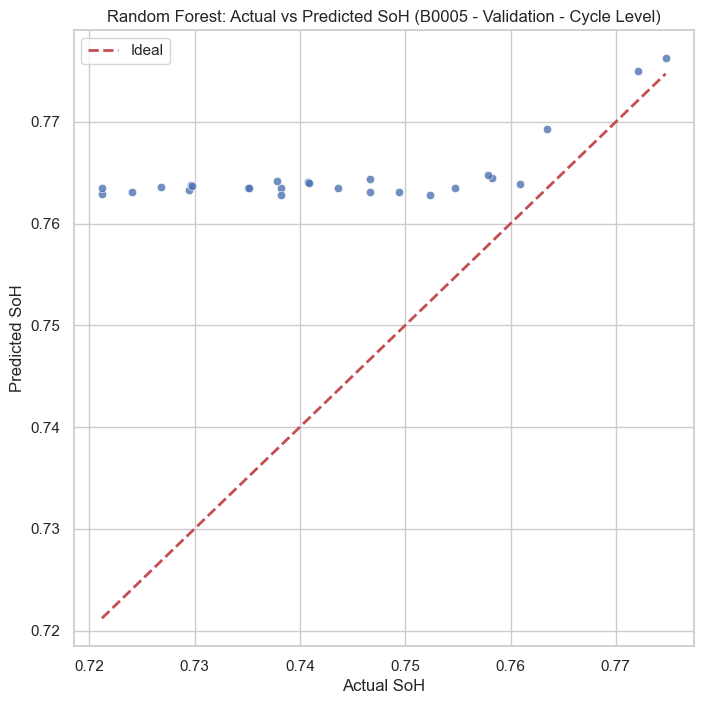


 Feature Importances (Cycle Level):


,Feature,Importance
8,discharge_time_s,0.367416
0,cycle_number,0.342804
7,delta_temp_measured,0.170618
2,avg_voltage_measured,0.075344
4,avg_current_measured,0.040642
6,max_temp_measured,0.002124
5,avg_temp_measured,0.000818
3,min_voltage_measured,0.000234
1,ambient_temperature,0.000000


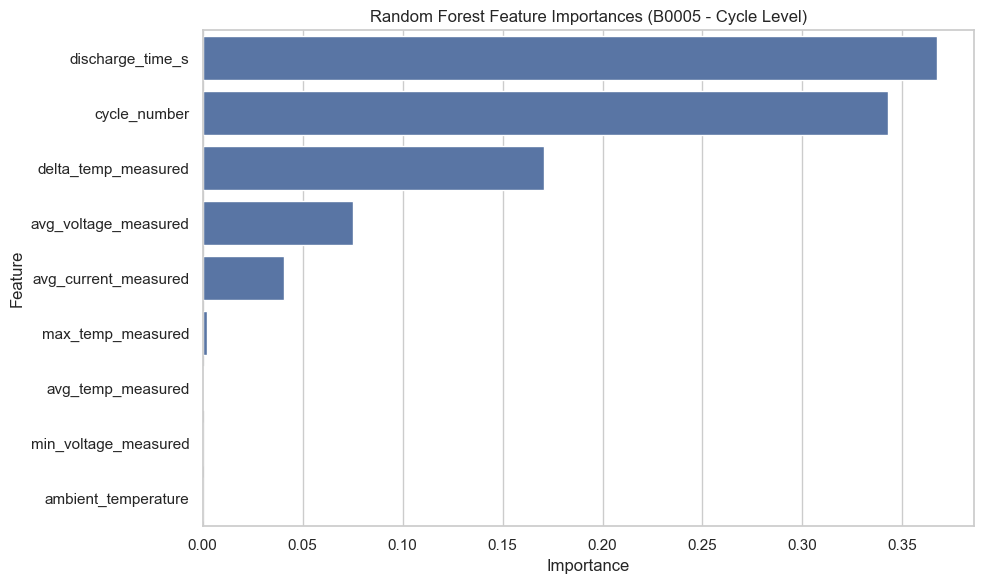


 Saving cycle-level model to ../models/random_forest_B0005_soh_cycle_v1.pkl...
  Model saved.


In [6]:
if 'X_train' in locals() and not X_train.empty and 'feature_cols' in locals(): # Check if cycle-level data is ready
    print(f"\nTraining Random Forest Regressor for {BATTERY_ID_TO_PROCESS} (CYCLE LEVEL)...")

    rf_model_cycle = RandomForestRegressor( # Use a new variable name for the model
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,   # Can relax these slightly for cycle-level
        min_samples_leaf=1,    # Can relax these slightly for cycle-level
        n_jobs=-1,
        random_state=42,
        oob_score=True
    )

    start_time = time.time()
    rf_model_cycle.fit(X_train, y_train) # Use cycle-level X_train, y_train
    end_time = time.time()
    print(f" Training complete in {end_time - start_time:.2f} seconds.")

    # --- Evaluate ---
    print("\n Evaluating on Validation Set (CYCLE LEVEL)...")
    if not X_val.empty:
        y_pred_val = rf_model_cycle.predict(X_val) # Use cycle-level X_val

        mae_val = mean_absolute_error(y_val, y_pred_val)
        # Recalculate RMSE manually
        mse_val = mean_squared_error(y_val, y_pred_val)
        rmse_val = np.sqrt(mse_val)
        r2_val = r2_score(y_val, y_pred_val)
        try: # OOB score might fail if n_estimators is small or data is tricky
            oob_score = rf_model_cycle.oob_score_
        except AttributeError:
            oob_score = np.nan # Handle cases where OOB is not computed


        print(f"  Validation MAE:  {mae_val:.4f}")
        print(f"  Validation RMSE: {rmse_val:.4f}")
        print(f"  Validation R2:   {r2_val:.4f}")
        print(f"  OOB Score (R2):  {oob_score:.4f}")

        # --- Visualize ---
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.8) # Use y_val from this cell's scope
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2, label='Ideal')
        plt.title(f'Random Forest: Actual vs Predicted SoH ({BATTERY_ID_TO_PROCESS} - Validation - Cycle Level)')
        plt.xlabel('Actual SoH')
        plt.ylabel('Predicted SoH')
        plt.legend()
        plt.grid(True)
        val_pred_filename = os.path.join(VISUALIZATION_DIR, f'rf_cycle_val_pred_{BATTERY_ID_TO_PROCESS}.png')
        plt.savefig(val_pred_filename)
        plt.show()

    else:
        print("  Validation set is empty, skipping evaluation plots.")

    # --- Feature Importances ---
    print("\n Feature Importances (Cycle Level):")
    importances = rf_model_cycle.feature_importances_
    # Ensure feature_cols matches the columns used in X_train (defined in the previous cell)
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    display(feature_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Random Forest Feature Importances ({BATTERY_ID_TO_PROCESS} - Cycle Level)')
    plt.tight_layout()
    feature_imp_filename = os.path.join(VISUALIZATION_DIR, f'rf_cycle_feat_imp_{BATTERY_ID_TO_PROCESS}.png')
    plt.savefig(feature_imp_filename)
    plt.show()

    # --- Save the Model ---
    model_filename = os.path.join(MODEL_DIR, f'random_forest_{BATTERY_ID_TO_PROCESS}_soh_cycle_v1.pkl') # New filename
    print(f"\n Saving cycle-level model to {model_filename}...")
    try:
        with open(model_filename, 'wb') as f: pickle.dump(rf_model_cycle, f)
        print("  Model saved.")
    except Exception as e:
        print(f"  Error saving model: {e}")

else:
    print("\nCannot train model, prepared cycle-level training data not found.")

## Evaluate on Test Set (CYCLE LEVEL)


Evaluating Random Forest on Test Set (B0005 - CYCLE LEVEL)...
  Test MAE:  0.0554
  Test RMSE: 0.0561
  Test R2:   -39.0198


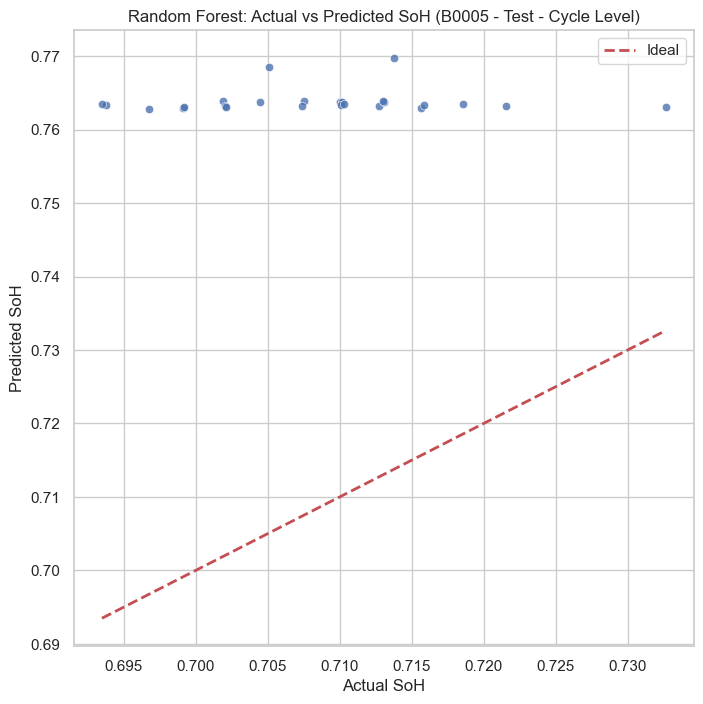

In [7]:
if 'rf_model_cycle' in locals() and 'X_test' in locals() and not X_test.empty:
    print(f"\nEvaluating Random Forest on Test Set ({BATTERY_ID_TO_PROCESS} - CYCLE LEVEL)...")

    y_pred_test = rf_model_cycle.predict(X_test) # Use cycle-level X_test

    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"  Test MAE:  {mae_test:.4f}")
    print(f"  Test RMSE: {rmse_test:.4f}")
    print(f"  Test R2:   {r2_test:.4f}")

    # --- Visualize Test Predictions ---
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Ideal')
    plt.title(f'Random Forest: Actual vs Predicted SoH ({BATTERY_ID_TO_PROCESS} - Test - Cycle Level)')
    plt.xlabel('Actual SoH')
    plt.ylabel('Predicted SoH')
    plt.legend()
    plt.grid(True)
    test_pred_filename = os.path.join(VISUALIZATION_DIR, f'rf_cycle_test_pred_{BATTERY_ID_TO_PROCESS}.png')
    plt.savefig(test_pred_filename)
    plt.show()

else:
    print("\nSkipping test set evaluation: Model or test data not found/empty.")

## Baseline Model 2: XGBoost Regressor 


Training XGBoost Regressor for B0005 (CYCLE LEVEL)...
 Training complete in 0.02 seconds.
 Best iteration found by early stopping: 9

 Evaluating XGBoost on Validation Set...
  Validation MAE (XGBoost):  0.1064
  Validation RMSE (XGBoost): 0.1074
  Validation R2 (XGBoost):   -52.1583


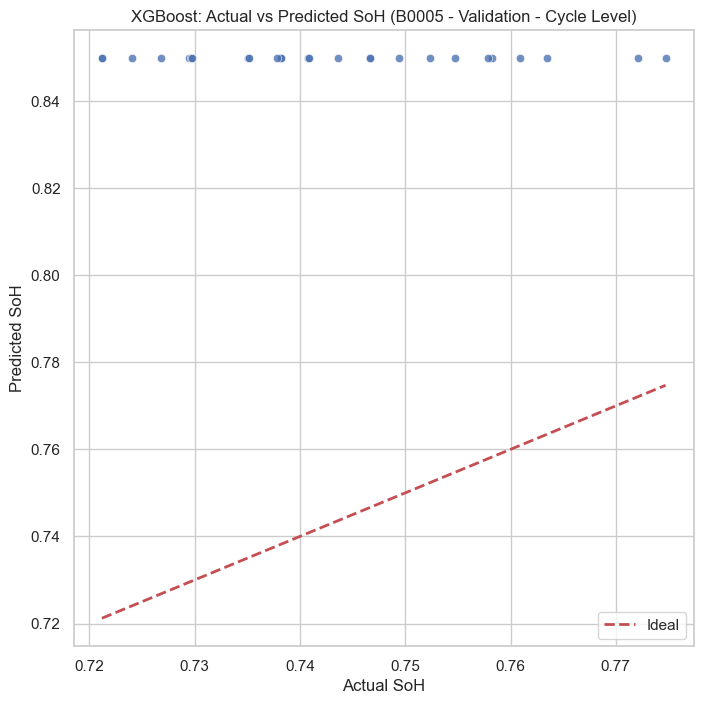


 XGBoost Feature Importances:


,Feature,Importance
8,discharge_time_s,0.439550
0,cycle_number,0.330829
2,avg_voltage_measured,0.229621
1,ambient_temperature,0.000000
3,min_voltage_measured,0.000000
4,avg_current_measured,0.000000
5,avg_temp_measured,0.000000
6,max_temp_measured,0.000000
7,delta_temp_measured,0.000000


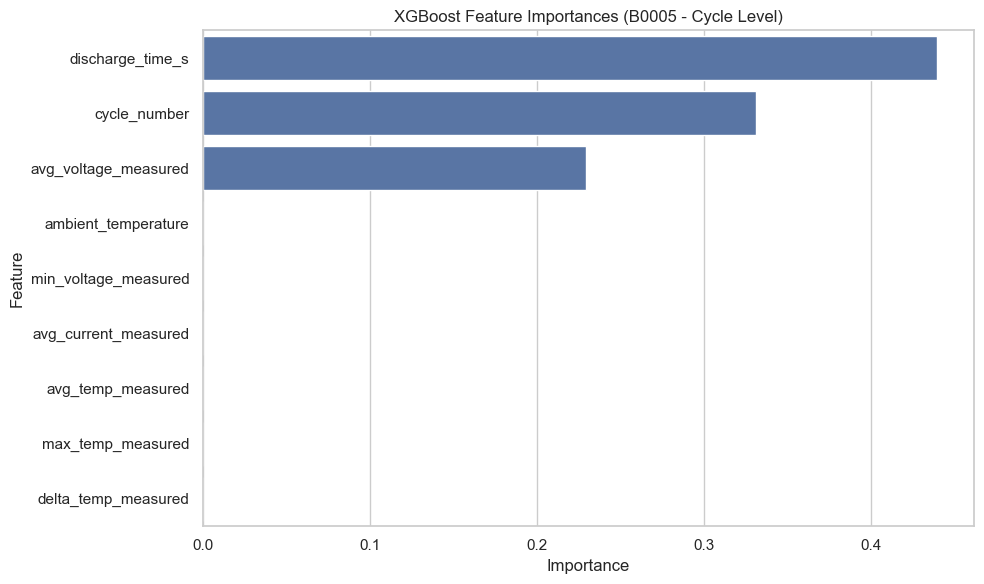


 Evaluating XGBoost on Test Set (B0005 - CYCLE LEVEL)...
  Test MAE (XGBoost):  0.1414
  Test RMSE (XGBoost): 0.1417
  Test R2 (XGBoost):   -253.8915


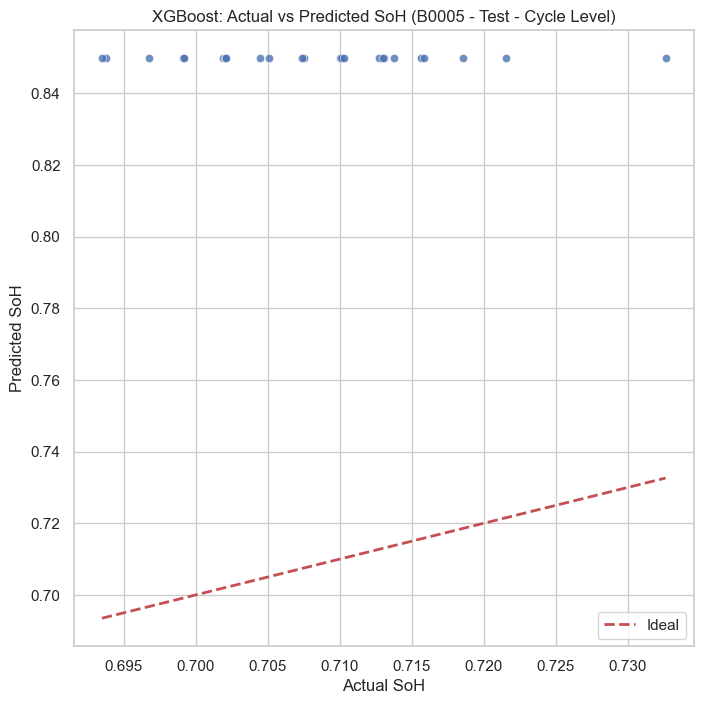


 Saving XGBoost model to ../models/xgboost_B0005_soh_cycle_v1.pkl...
  Model saved.


In [8]:
import xgboost as xgb

if 'X_train' in locals() and not X_train.empty: # Check if cycle-level data is ready
    print(f"\nTraining XGBoost Regressor for {BATTERY_ID_TO_PROCESS} (CYCLE LEVEL)...")

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=10 # ADD IT HERE
    )

    start_time = time.time()
    # XGBoost can use validation set for early stopping if needed
    eval_set = [(X_val, y_val)] # Often better to use only validation set for early stopping
    xgb_model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False # Keep verbose=False unless debugging needed
        # early_stopping_rounds=10 # REMOVE FROM HERE
    )
    end_time = time.time()
    print(f" Training complete in {end_time - start_time:.2f} seconds.")
    print(f" Best iteration found by early stopping: {xgb_model.best_iteration}")


    # --- Evaluate ---
    print("\n Evaluating XGBoost on Validation Set...")
    if not X_val.empty:
        y_pred_val_xgb = xgb_model.predict(X_val)

        mae_val_xgb = mean_absolute_error(y_val, y_pred_val_xgb)
        mse_val_xgb = mean_squared_error(y_val, y_pred_val_xgb)
        rmse_val_xgb = np.sqrt(mse_val_xgb)
        r2_val_xgb = r2_score(y_val, y_pred_val_xgb)

        print(f"  Validation MAE (XGBoost):  {mae_val_xgb:.4f}")
        print(f"  Validation RMSE (XGBoost): {rmse_val_xgb:.4f}")
        print(f"  Validation R2 (XGBoost):   {r2_val_xgb:.4f}")

        # --- Visualize ---
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_val, y=y_pred_val_xgb, alpha=0.8)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2, label='Ideal')
        plt.title(f'XGBoost: Actual vs Predicted SoH ({BATTERY_ID_TO_PROCESS} - Validation - Cycle Level)')
        plt.xlabel('Actual SoH')
        plt.ylabel('Predicted SoH')
        plt.legend()
        plt.grid(True)
        xgb_val_pred_filename = os.path.join(VISUALIZATION_DIR, f'xgb_cycle_val_pred_{BATTERY_ID_TO_PROCESS}.png')
        plt.savefig(xgb_val_pred_filename)
        plt.show()

    else:
        print("  Validation set is empty, skipping evaluation plots.")

    # --- Feature Importances (XGBoost) ---
    print("\n XGBoost Feature Importances:")
    importances_xgb = xgb_model.feature_importances_
    feature_importance_df_xgb = pd.DataFrame({
        'Feature': feature_cols, # Assumes feature_cols is still available from previous cell
        'Importance': importances_xgb
    }).sort_values(by='Importance', ascending=False)

    display(feature_importance_df_xgb)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb)
    plt.title(f'XGBoost Feature Importances ({BATTERY_ID_TO_PROCESS} - Cycle Level)')
    plt.tight_layout()
    xgb_feature_imp_filename = os.path.join(VISUALIZATION_DIR, f'xgb_cycle_feat_imp_{BATTERY_ID_TO_PROCESS}.png')
    plt.savefig(xgb_feature_imp_filename)
    plt.show()

    # --- Evaluate on Test Set ---
    if 'X_test' in locals() and not X_test.empty:
        print(f"\n Evaluating XGBoost on Test Set ({BATTERY_ID_TO_PROCESS} - CYCLE LEVEL)...")

        y_pred_test_xgb = xgb_model.predict(X_test)

        mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
        mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
        rmse_test_xgb = np.sqrt(mse_test_xgb)
        r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

        print(f"  Test MAE (XGBoost):  {mae_test_xgb:.4f}")
        print(f"  Test RMSE (XGBoost): {rmse_test_xgb:.4f}")
        print(f"  Test R2 (XGBoost):   {r2_test_xgb:.4f}")

        # Visualize Test
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_test, y=y_pred_test_xgb, alpha=0.8)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Ideal')
        plt.title(f'XGBoost: Actual vs Predicted SoH ({BATTERY_ID_TO_PROCESS} - Test - Cycle Level)')
        plt.xlabel('Actual SoH')
        plt.ylabel('Predicted SoH')
        plt.legend()
        plt.grid(True)
        xgb_test_pred_filename = os.path.join(VISUALIZATION_DIR, f'xgb_cycle_test_pred_{BATTERY_ID_TO_PROCESS}.png')
        plt.savefig(xgb_test_pred_filename)
        plt.show()
    else:
        print("\n Skipping XGBoost test set evaluation: Test data not found/empty.")


    # --- Save the XGBoost Model ---
    model_filename_xgb = os.path.join(MODEL_DIR, f'xgboost_{BATTERY_ID_TO_PROCESS}_soh_cycle_v1.pkl') # Use .pkl for consistency or .json/.ubj for native save
    print(f"\n Saving XGBoost model to {model_filename_xgb}...")
    try:

        with open(model_filename_xgb, 'wb') as f: pickle.dump(xgb_model, f)

        print("  Model saved.")
    except Exception as e:
        print(f"  Error saving XGBoost model: {e}")

else:
    print("\nCannot train XGBoost model, prepared cycle-level training data not found.")

## LSTM TEST

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint


print(f"Loading preprocessed data for battery: {BATTERY_ID_TO_PROCESS}")
csv_filename = f'nasa_battery_data_{BATTERY_ID_TO_PROCESS}_preprocessed.csv'
csv_filepath = os.path.join(PROCESSED_DATA_DIR, csv_filename)
try:
    df_battery = pd.read_csv(csv_filepath)
    print(f"Successfully loaded {csv_filename}. Shape: {df_battery.shape}")
except Exception as e:
    print(f"Error loading CSV: {e}")
    df_battery = None # Handle error

Loading preprocessed data for battery: B0005
Successfully loaded nasa_battery_data_B0005_preprocessed.csv. Shape: (591458, 18)


In [10]:
if df_battery is not None:
    print(f"\nSplitting data for {BATTERY_ID_TO_PROCESS}...")

    # Get unique cycle numbers sorted
    unique_cycles = np.sort(df_battery['cycle_number'].unique())
    n_cycles = len(unique_cycles)
    print(f" Total unique cycles: {n_cycles}")

    if n_cycles < 3:
        print(f" Not enough cycles to split {BATTERY_ID_TO_PROCESS}. Skipping further steps.")
    else:
        train_split_ratio = 0.70
        val_split_ratio = 0.15

        train_end_cycle = unique_cycles[int(n_cycles * train_split_ratio) - 1]
        val_end_cycle = unique_cycles[int(n_cycles * (train_split_ratio + val_split_ratio)) - 1]

        print(f"  Train cycles: Up to {train_end_cycle}")
        print(f"  Validation cycles: {train_end_cycle + 1} to {val_end_cycle}")
        print(f"  Test cycles: From {val_end_cycle + 1}")

        # Create masks
        train_mask = df_battery['cycle_number'] <= train_end_cycle
        val_mask = (df_battery['cycle_number'] > train_end_cycle) & (df_battery['cycle_number'] <= val_end_cycle)
        test_mask = df_battery['cycle_number'] > val_end_cycle

        # Apply masks
        df_train = df_battery[train_mask].copy()
        df_val = df_battery[val_mask].copy()
        df_test = df_battery[test_mask].copy()

        print(f"\n  Train set shape: {df_train.shape}")
        print(f"  Validation set shape: {df_val.shape}")
        print(f"  Test set shape: {df_test.shape}")

        # Verify split ranges
        if not df_train.empty: print(f"  Train cycles range: {df_train['cycle_number'].min()} - {df_train['cycle_number'].max()}")
        if not df_val.empty: print(f"  Val cycles range:   {df_val['cycle_number'].min()} - {df_val['cycle_number'].max()}")
        if not df_test.empty: print(f"  Test cycles range:  {df_test['cycle_number'].min()} - {df_test['cycle_number'].max()}")

else:
    print("Cannot split data, DataFrame not loaded.")


Splitting data for B0005...
 Total unique cycles: 338
  Train cycles: Up to 421
  Validation cycles: 422 to 517
  Test cycles: From 518

  Train set shape: (389524, 18)
  Validation set shape: (102228, 18)
  Test set shape: (99706, 18)
  Train cycles range: 1 - 421
  Val cycles range:   423 - 517
  Test cycles range:  519 - 616


### Prepare Data as Sequences for LSTM (SoH Prediction)

In [11]:
if 'df_train' in locals():
    print(f"\nPreparing sequence data for LSTM (SoH) for {BATTERY_ID_TO_PROCESS}...")

    # --- Define features for LSTM sequence ---
    # Use the time-varying smoothed measurements
    sequence_features = [
        'voltage_measured_smooth',
        'current_measured_smooth',
        'temperature_measured_smooth',
        # Optional: Add time relative? Or other instantaneous features?
        'measurement_time_relative'
    ]
    target_col = 'soh'
    print(f" Using sequence features: {sequence_features}")
    print(f" Using target: {target_col}")

    # --- Function to create sequences and filter ---
    def create_sequences(df_split, features, target, group_cols=['battery_id', 'cycle_number']):
        # Keep only discharge cycles where SoH target is available
        df_filtered = df_split[df_split['cycle_type'] == 'discharge'].dropna(subset=[target]).copy()
        if df_filtered.empty:
            return [], np.array([]) # Return empty lists/arrays

        # Group by cycle
        grouped = df_filtered.groupby(group_cols)

        # Extract sequences and corresponding single target value per sequence
        sequences = [group[features].values for name, group in grouped]
        targets = [group[target].iloc[0] for name, group in grouped] # SoH is constant per cycle

        return sequences, np.array(targets)

    # --- Create sequences for Train, Val, Test ---
    X_train_list, y_train_seq = create_sequences(df_train, sequence_features, target_col)
    X_val_list, y_val_seq = create_sequences(df_val, sequence_features, target_col)
    X_test_list, y_test_seq = create_sequences(df_test, sequence_features, target_col)

    if not X_train_list:
        print(" Error: No sequences generated for training set. Cannot proceed.")
         # Handle error
    else:
        print(f" Number of training sequences: {len(X_train_list)}")
        print(f" Number of validation sequences: {len(X_val_list)}")
        print(f" Number of test sequences: {len(X_test_list)}")
        print(f" Example training sequence shape: {X_train_list[0].shape}") # (timesteps, features)
        print(f" Example training target shape: {y_train_seq.shape}") # Should be (num_sequences,)


        print("\n Scaling sequence features...")
        scaler_lstm = StandardScaler()

        # Concatenate all training sequences for fitting the scaler
        # Handle potential empty sequences if any cycle had issues (though unlikely after filtering)
        train_sequences_stacked = np.vstack([seq for seq in X_train_list if seq.shape[0] > 0])
        scaler_lstm.fit(train_sequences_stacked)

        # Apply scaling to each sequence in each set
        X_train_scaled_list = [scaler_lstm.transform(seq) for seq in X_train_list if seq.shape[0] > 0]
        X_val_scaled_list = [scaler_lstm.transform(seq) for seq in X_val_list if seq.shape[0] > 0]
        X_test_scaled_list = [scaler_lstm.transform(seq) for seq in X_test_list if seq.shape[0] > 0]

        # Adjust targets if lists got shorter due to empty sequences (unlikely here)
        y_train_seq = y_train_seq[[i for i, seq in enumerate(X_train_list) if seq.shape[0] > 0]]
        y_val_seq = y_val_seq[[i for i, seq in enumerate(X_val_list) if seq.shape[0] > 0]]
        y_test_seq = y_test_seq[[i for i, seq in enumerate(X_test_list) if seq.shape[0] > 0]]
        print(" Scaling complete.")

        # --- Pad Sequences ---
        # Find max sequence length for padding
        max_len_train = max(len(seq) for seq in X_train_scaled_list)
        max_len_val = max(len(seq) for seq in X_val_scaled_list) if X_val_scaled_list else 0
        max_len_test = max(len(seq) for seq in X_test_scaled_list) if X_test_scaled_list else 0
        max_sequence_length = max(max_len_train, max_len_val, max_len_test)
        print(f" Max sequence length found: {max_sequence_length}")

        # Pad sequences (post-padding is common) - use a value like 0, will use Masking layer later
        X_train_pad = pad_sequences(X_train_scaled_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0.0)
        X_val_pad = pad_sequences(X_val_scaled_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0.0)
        X_test_pad = pad_sequences(X_test_scaled_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0.0)

        print("\n Padding complete.")
        print(f" Padded training sequences shape: {X_train_pad.shape}") # (num_sequences, max_len, num_features)
        print(f" Padded validation sequences shape: {X_val_pad.shape}")
        print(f" Padded test sequences shape: {X_test_pad.shape}")

        # --- Save Scaler ---
        scaler_lstm_filename = os.path.join(MODEL_DIR, f'scaler_lstm_{BATTERY_ID_TO_PROCESS}_soh.pkl')
        try:
            with open(scaler_lstm_filename, 'wb') as f: pickle.dump(scaler_lstm, f)
            print(f" Saved LSTM scaler to {scaler_lstm_filename}")
        except Exception as e:
            print(f" Error saving LSTM scaler: {e}")
else:
    print("Cannot prepare sequences, data splits not found.")


Preparing sequence data for LSTM (SoH) for B0005...
 Using sequence features: ['voltage_measured_smooth', 'current_measured_smooth', 'temperature_measured_smooth', 'measurement_time_relative']
 Using target: soh
 Number of training sequences: 117
 Number of validation sequences: 26
 Number of test sequences: 25
 Example training sequence shape: (197, 4)
 Example training target shape: (117,)

 Scaling sequence features...
 Scaling complete.
 Max sequence length found: 371

 Padding complete.
 Padded training sequences shape: (117, 371, 4)
 Padded validation sequences shape: (26, 371, 4)
 Padded test sequences shape: (25, 371, 4)
 Saved LSTM scaler to ../models/scaler_lstm_B0005_soh.pkl


### Build and Train LSTM Model


Building LSTM model for B0005...


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 371, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.2678 - mae: 0.4624 - val_loss: 0.0014 - val_mae: 0.0348
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0464 - mae: 0.1682 - val_loss: 0.0791 - val_mae: 0.2811
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0935 - mae: 0.2603 - val_loss: 0.0182 - val_mae: 0.1345
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0515 - mae: 0.1837 - val_loss: 0.0015 - val_mae: 0.0356
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0463 - mae: 0.1743 - val_loss: 0.0059 - val_mae: 0.0758
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0417 - mae: 0.1618 - val_loss: 4.0362e-04 - val_mae: 0.0160
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0264 - mae: 0.1319 - val_loss: 0.0065 - val_mae: 0.0797
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0311 - mae: 0.1434 - val_loss: 0.0130 - val_mae: 0.1136
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - 

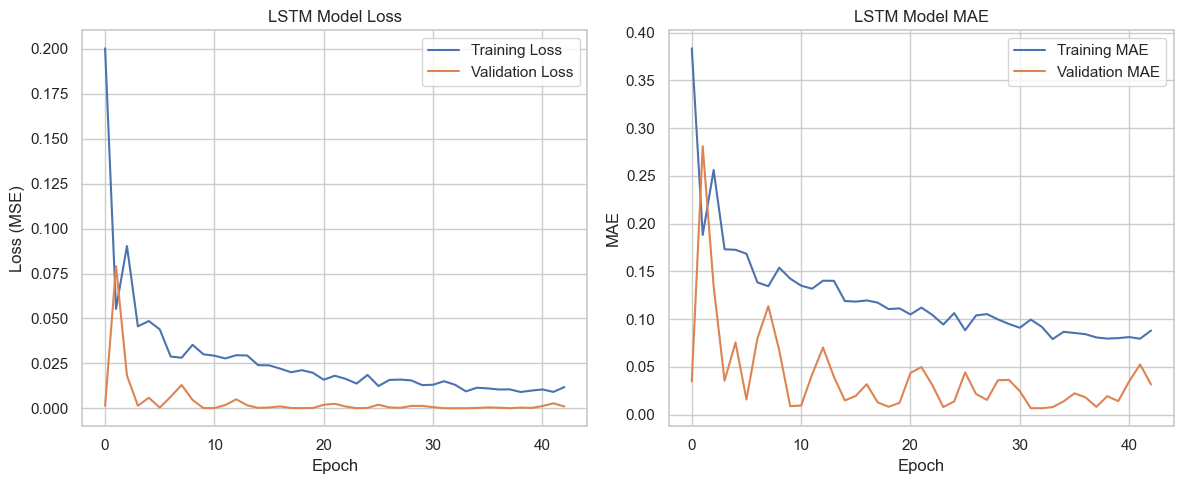


Loading best model weights from ../models/lstm_B0005_soh_best.keras

Evaluating LSTM on Validation Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
  Validation MAE (LSTM):  0.0068
  Validation RMSE (LSTM): 0.0078
  Validation R2 (LSTM):   0.7162


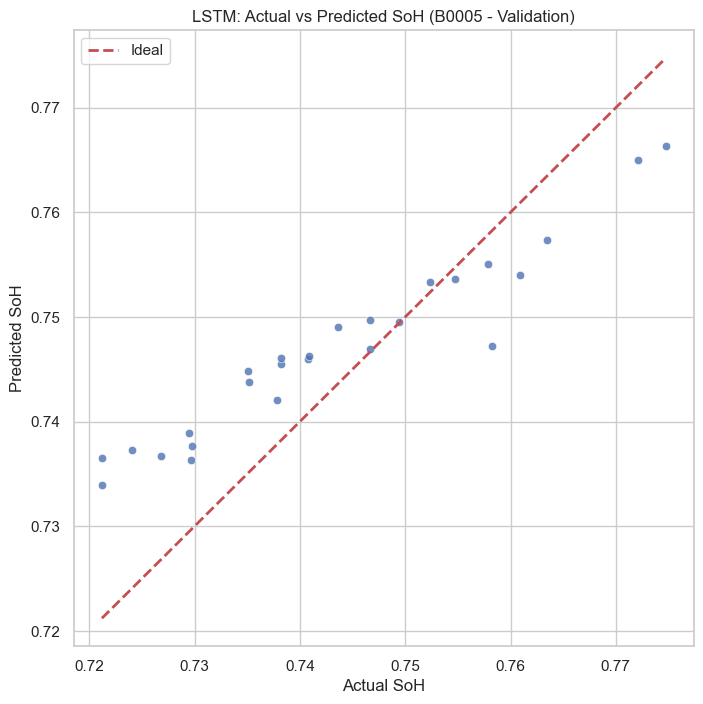


Evaluating LSTM on Test Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
  Test MAE (LSTM):  0.0208
  Test RMSE (LSTM): 0.0211
  Test R2 (LSTM):   -4.6323


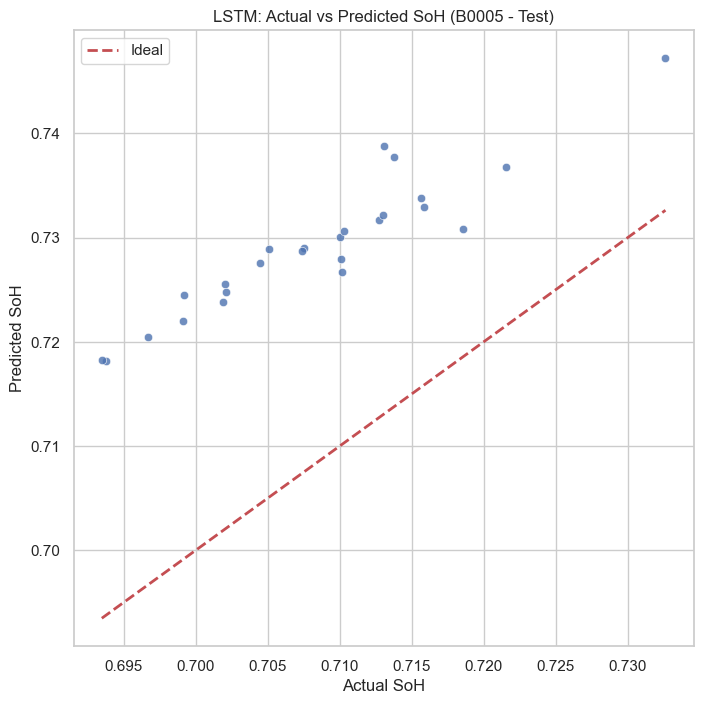


Plotting Training Data, Test Actuals, and Test Predictions vs Cycle...


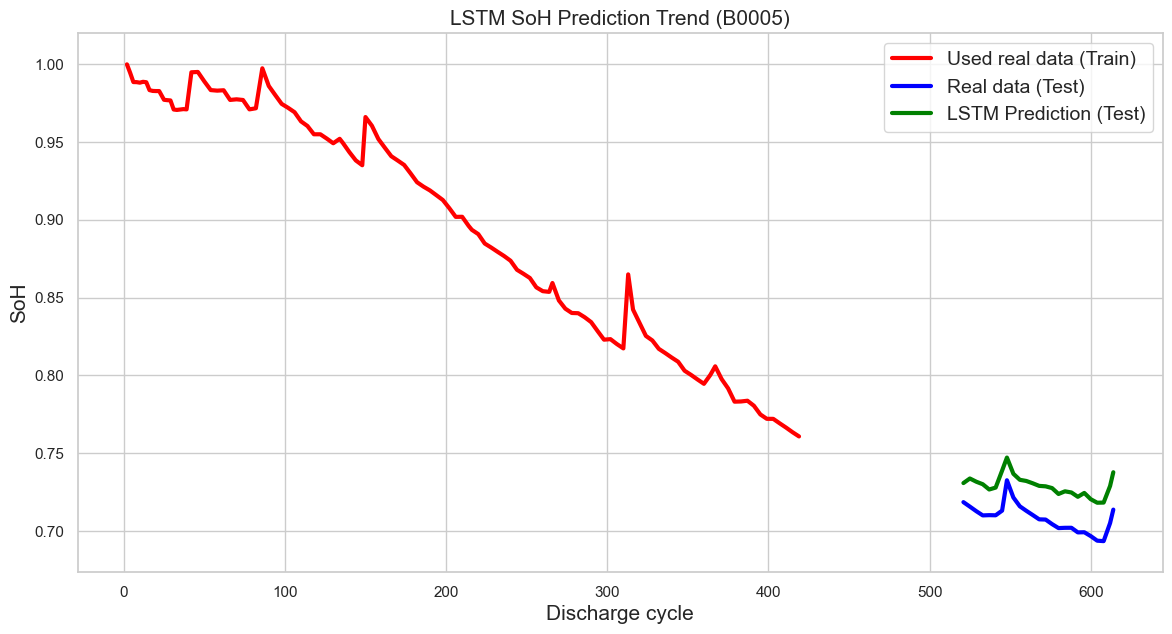

In [12]:
if 'X_train_pad' in locals() and X_train_pad.shape[0] > 0: # Check if sequence data is ready
    print(f"\nBuilding LSTM model for {BATTERY_ID_TO_PROCESS}...")

    n_features = X_train_pad.shape[2] # Number of features per timestep
    sequence_length = X_train_pad.shape[1] # Max sequence length after padding

    model_lstm = Sequential()
    # Masking layer ignores padding (value=0.0)
    model_lstm.add(Masking(mask_value=0.0, input_shape=(sequence_length, n_features)))
    # LSTM layer(s)
    model_lstm.add(LSTM(units=50, activation='tanh', return_sequences=False)) # return_sequences=False as it's the last LSTM layer before Dense
    # Dropout for regularization
    model_lstm.add(Dropout(0.2))
    # Output layer for regression
    model_lstm.add(Dense(units=1, activation='linear')) # Linear activation for regression

    # Compile the model
    model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    model_lstm.summary()

    # --- Train the Model ---
    print("\nTraining LSTM model...")

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint_path = os.path.join(MODEL_DIR, f'lstm_{BATTERY_ID_TO_PROCESS}_soh_best.keras') # Use .keras format
    model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

    epochs = 50 # Adjust as needed
    batch_size = 32 # Adjust as needed

    history = model_lstm.fit(
        X_train_pad, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_pad, y_val_seq),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1 # Show training progress
    )

    print("\nLSTM Training complete.")

    # --- Plot Training History ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('LSTM Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    lstm_history_filename = os.path.join(VISUALIZATION_DIR, f'lstm_history_{BATTERY_ID_TO_PROCESS}.png')
    plt.savefig(lstm_history_filename)
    plt.show()

    # --- Load Best Model from Checkpoint ---
    print(f"\nLoading best model weights from {model_checkpoint_path}")
    try:
        model_lstm.load_weights(model_checkpoint_path)
    except Exception as e:
        print(f"Could not load best weights: {e}")


    # --- Evaluate LSTM on Validation and Test Sets ---
    print("\nEvaluating LSTM on Validation Set...")
    if not X_val_pad.size == 0: # Check if validation set exists
        y_pred_val_lstm = model_lstm.predict(X_val_pad).flatten() # Flatten output
        mae_val_lstm = mean_absolute_error(y_val_seq, y_pred_val_lstm)
        mse_val_lstm = mean_squared_error(y_val_seq, y_pred_val_lstm)
        rmse_val_lstm = np.sqrt(mse_val_lstm)
        r2_val_lstm = r2_score(y_val_seq, y_pred_val_lstm)
        print(f"  Validation MAE (LSTM):  {mae_val_lstm:.4f}")
        print(f"  Validation RMSE (LSTM): {rmse_val_lstm:.4f}")
        print(f"  Validation R2 (LSTM):   {r2_val_lstm:.4f}")

        # Visualize Validation
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_val_seq, y=y_pred_val_lstm, alpha=0.8)
        plt.plot([y_val_seq.min(), y_val_seq.max()], [y_val_seq.min(), y_val_seq.max()], '--r', linewidth=2, label='Ideal')
        plt.title(f'LSTM: Actual vs Predicted SoH ({BATTERY_ID_TO_PROCESS} - Validation)')
        plt.xlabel('Actual SoH')
        plt.ylabel('Predicted SoH')
        plt.legend()
        plt.grid(True)
        lstm_val_pred_filename = os.path.join(VISUALIZATION_DIR, f'lstm_cycle_val_pred_{BATTERY_ID_TO_PROCESS}.png')
        plt.savefig(lstm_val_pred_filename)
        plt.show()
        
    

    print("\nEvaluating LSTM on Test Set...")
    if not X_test_pad.size == 0: # Check if test set exists
        y_pred_test_lstm = model_lstm.predict(X_test_pad).flatten()
        mae_test_lstm = mean_absolute_error(y_test_seq, y_pred_test_lstm)
        mse_test_lstm = mean_squared_error(y_test_seq, y_pred_test_lstm)
        rmse_test_lstm = np.sqrt(mse_test_lstm)
        r2_test_lstm = r2_score(y_test_seq, y_pred_test_lstm)
        print(f"  Test MAE (LSTM):  {mae_test_lstm:.4f}")
        print(f"  Test RMSE (LSTM): {rmse_test_lstm:.4f}")
        print(f"  Test R2 (LSTM):   {r2_test_lstm:.4f}")

        # Visualize Test
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_test_seq, y=y_pred_test_lstm, alpha=0.8)
        plt.plot([y_test_seq.min(), y_test_seq.max()], [y_test_seq.min(), y_test_seq.max()], '--r', linewidth=2, label='Ideal')
        plt.title(f'LSTM: Actual vs Predicted SoH ({BATTERY_ID_TO_PROCESS} - Test)')
        plt.xlabel('Actual SoH')
        plt.ylabel('Predicted SoH')
        plt.legend()
        plt.grid(True)
        lstm_test_pred_filename = os.path.join(VISUALIZATION_DIR, f'lstm_cycle_test_pred_{BATTERY_ID_TO_PROCESS}.png')
        plt.savefig(lstm_test_pred_filename)
        plt.show()
    else:
        print(" Test set empty or not found, skipping test evaluation.")
    
    # --- Visualize Test Predictions vs Actual Trend (like reference notebook) ---
    if not X_test_pad.size == 0 and 'df_train_filtered' in locals() and 'df_test_filtered' in locals() :
        print("\nPlotting Training Data, Test Actuals, and Test Predictions vs Cycle...")

        # Extract cycle numbers and SoH for training (used portion)
        # Need one SoH per cycle for plotting the trend
        train_plot_data = df_train_filtered[['cycle_number', 'soh']].drop_duplicates().sort_values('cycle_number')

        # Extract cycle numbers and SoH for test actuals
        # Need to align with y_test_seq (which matches X_test_list order)
        test_plot_data_actual = df_test_filtered[['cycle_number', 'soh']].drop_duplicates().sort_values('cycle_number')

        # Check if the lengths match the predictions (y_pred_test_lstm was based on X_test_pad/y_test_seq)
        # The number of predicted points should match the number of unique cycles in the filtered test set
        if len(test_plot_data_actual) == len(y_pred_test_lstm):
            test_plot_data_pred = pd.DataFrame({
                'cycle_number': test_plot_data_actual['cycle_number'],
                'predicted_soh': y_pred_test_lstm
            })

            plt.figure(figsize=(14, 7))
            plt.plot(train_plot_data['cycle_number'], train_plot_data['soh'], label='Used real data (Train)', linewidth=3, color='red')
            plt.plot(test_plot_data_actual['cycle_number'], test_plot_data_actual['soh'], label='Real data (Test)', linewidth=3, color='blue')
            plt.plot(test_plot_data_pred['cycle_number'], test_plot_data_pred['predicted_soh'], label='LSTM Prediction (Test)', linewidth=3, color='green', linestyle='-') # Use solid line for clarity maybe

            plt.title(f'LSTM SoH Prediction Trend ({BATTERY_ID_TO_PROCESS})', fontsize=15)
            plt.xlabel('Discharge cycle', fontsize=15)
            plt.ylabel('SoH', fontsize=15)
            plt.legend(prop={'size': 14})
            plt.grid(True)
            plt.ylim(min(test_plot_data_actual['soh'].min(), test_plot_data_pred['predicted_soh'].min()) - 0.02,
                     train_plot_data['soh'].max() + 0.02) # Adjust y-limits for better view

            lstm_trend_filename = os.path.join(VISUALIZATION_DIR, f'lstm_trend_pred_{BATTERY_ID_TO_PROCESS}.png')
            plt.savefig(lstm_trend_filename)
            plt.show()
        else:
             print(f" Warning: Mismatch between number of test cycles ({len(test_plot_data_actual)}) and predictions ({len(y_pred_test_lstm)}). Cannot create trend plot.")

    else:
        print("\n Skipping trend plot: Test data/predictions not available or relevant dataframes missing.")


else:
    print("\nCannot build/train LSTM model, prepared sequence data not found.")

### Re-train LSTM on Train + Validation Data


Re-training final LSTM model on combined Train + Validation data...
 Combined Train+Val data shape: X=(143, 371, 4), y=(143,)


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 371, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)


Training final model for 20 epochs...
 Final model training complete.

Evaluating final LSTM on Test Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
  FINAL Test MAE (LSTM):  0.0279
  FINAL Test RMSE (LSTM): 0.0284
  FINAL Test R2 (LSTM):   -9.2225


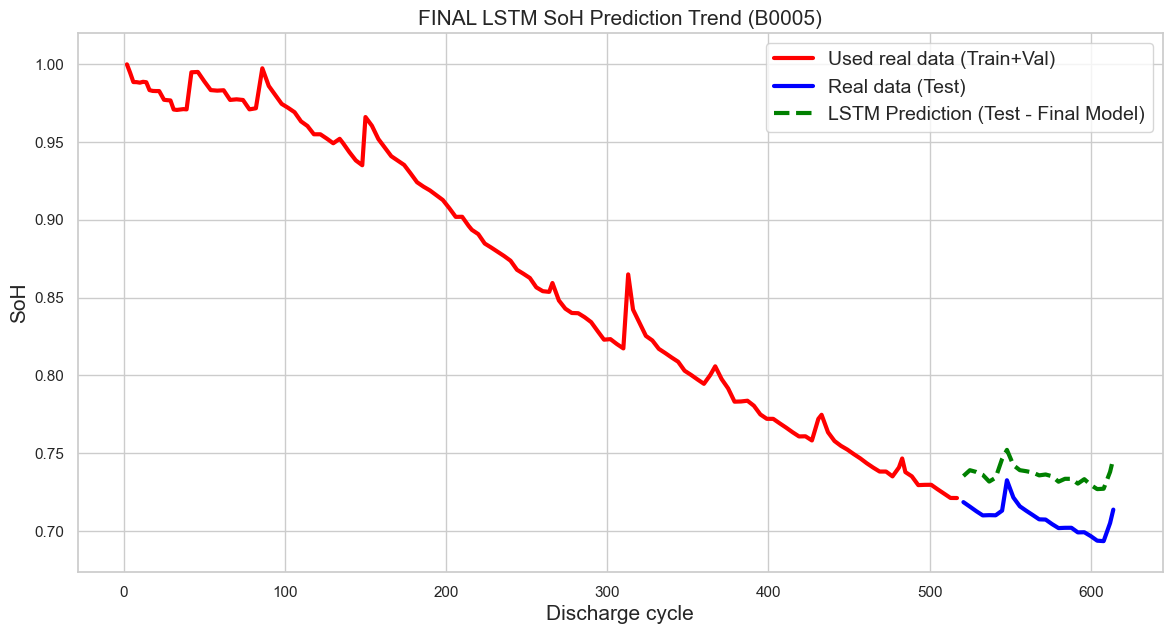

In [13]:
if ('X_train_pad' in locals() and 'X_val_pad' in locals() and
    y_train_seq.size > 0 and y_val_seq.size > 0): # Check data exists

    print("\nRe-training final LSTM model on combined Train + Validation data...")

    # --- Combine Data ---
    X_train_val_pad = np.concatenate((X_train_pad, X_val_pad), axis=0)
    y_train_val_seq = np.concatenate((y_train_seq, y_val_seq), axis=0)
    print(f" Combined Train+Val data shape: X={X_train_val_pad.shape}, y={y_train_val_seq.shape}")

    # --- Re-initialize Model Architecture ---
    n_features = X_train_val_pad.shape[2]
    sequence_length = X_train_val_pad.shape[1]

    model_final = Sequential()
    model_final.add(Masking(mask_value=0.0, input_shape=(sequence_length, n_features)))
    model_final.add(LSTM(units=50, activation='tanh', return_sequences=False))
    model_final.add(Dropout(0.2))
    model_final.add(Dense(units=1, activation='linear'))
    model_final.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model_final.summary()

    # --- Train on Combined Data ---
    # Choose epochs based on where validation loss plateaued before (e.g., ~10-20 epochs)
    # Or train longer if needed, but without early stopping based on val set now
    final_epochs = 20 # Adjust this based on previous history plot
    batch_size = 32

    print(f"\nTraining final model for {final_epochs} epochs...")
    history_final = model_final.fit(
        X_train_val_pad, y_train_val_seq,
        epochs=final_epochs,
        batch_size=batch_size,
        verbose=0 # Set to 1 to see progress
    )
    print(" Final model training complete.")

    # --- Evaluate Final Model on Test Set ---
    print("\nEvaluating final LSTM on Test Set...")
    if not X_test_pad.size == 0:
        y_pred_test_final = model_final.predict(X_test_pad).flatten()

        mae_test_final = mean_absolute_error(y_test_seq, y_pred_test_final)
        mse_test_final = mean_squared_error(y_test_seq, y_pred_test_final)
        rmse_test_final = np.sqrt(mse_test_final)
        r2_test_final = r2_score(y_test_seq, y_pred_test_final)

        print(f"  FINAL Test MAE (LSTM):  {mae_test_final:.4f}")
        print(f"  FINAL Test RMSE (LSTM): {rmse_test_final:.4f}")
        print(f"  FINAL Test R2 (LSTM):   {r2_test_final:.4f}") # This is the key metric now

        # --- Visualize Final Test Predictions vs Trend ---
        # Need original full training data for the red line (up to end of val split)
        df_train_val_filtered = df_battery[df_battery['cycle_number'] <= val_end_cycle].dropna(subset=[target_col]).copy()
        train_val_plot_data = df_train_val_filtered[['cycle_number', 'soh']].drop_duplicates().sort_values('cycle_number')

        # Test actuals (blue line) - Ensure alignment
        test_plot_data_actual = df_test_filtered[['cycle_number', 'soh']].drop_duplicates().sort_values('cycle_number')

        # Check alignment again (should still match if test set unchanged)
        if len(test_plot_data_actual) == len(y_pred_test_final):
            test_plot_data_pred_final = pd.DataFrame({
                'cycle_number': test_plot_data_actual['cycle_number'],
                'predicted_soh': y_pred_test_final
            })

            plt.figure(figsize=(14, 7))
            # Plot combined Train+Val actuals
            plt.plot(train_val_plot_data['cycle_number'], train_val_plot_data['soh'], label='Used real data (Train+Val)', linewidth=3, color='red')
            # Plot Test actuals
            plt.plot(test_plot_data_actual['cycle_number'], test_plot_data_actual['soh'], label='Real data (Test)', linewidth=3, color='blue')
            # Plot Test predictions from final model
            plt.plot(test_plot_data_pred_final['cycle_number'], test_plot_data_pred_final['predicted_soh'], label='LSTM Prediction (Test - Final Model)', linewidth=3, color='green', linestyle='--') # Dashed green

            plt.title(f'FINAL LSTM SoH Prediction Trend ({BATTERY_ID_TO_PROCESS})', fontsize=15)
            plt.xlabel('Discharge cycle', fontsize=15)
            plt.ylabel('SoH', fontsize=15)
            plt.legend(prop={'size': 14})
            plt.grid(True)
            plt.ylim(min(test_plot_data_actual['soh'].min(), test_plot_data_pred_final['predicted_soh'].min()) - 0.02,
                     train_val_plot_data['soh'].max() + 0.02)

            final_lstm_trend_filename = os.path.join(VISUALIZATION_DIR, f'lstm_final_trend_pred_{BATTERY_ID_TO_PROCESS}.png')
            plt.savefig(final_lstm_trend_filename)
            plt.show()
        else:
             print(f" Warning: Mismatch between number of final test cycles ({len(test_plot_data_actual)}) and final predictions ({len(y_pred_test_final)}). Cannot create final trend plot.")

    else:
        print(" Test set empty or not found, skipping final test evaluation.")

else:
    print("\nCannot re-train model, prepared sequence data not found.")


In [14]:
# --- Function to Train and Evaluate LSTM for SoH ---
# Import necessary libraries within the function scope or ensure they are imported globally
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_evaluate_lstm_soh(battery_id, data_dir, model_dir, viz_dir,
                           sequence_features, target_col='soh',
                           train_split_ratio=0.7, val_split_ratio=0.15,
                           lstm_units=50, dropout_rate=0.2,
                           epochs_initial=50, epochs_final=20, batch_size=32):
    """
    Loads data, prepares sequences, trains/evaluates LSTM for SoH for a specific battery.
    Includes re-training on Train+Val set for final evaluation.

    Args:
        battery_id (str): The ID of the battery (e.g., 'B0005').
        data_dir (str): Path to the directory with preprocessed CSVs.
        model_dir (str): Path to save models and scalers.
        viz_dir (str): Path to save visualizations.
        sequence_features (list): List of column names for sequence features.
        target_col (str): Name of the target column (SoH).
        train_split_ratio (float): Proportion for training set.
        val_split_ratio (float): Proportion for validation set.
        lstm_units (int): Number of units in the LSTM layer.
        dropout_rate (float): Dropout rate after LSTM layer.
        epochs_initial (int): Max epochs for initial training with early stopping.
        epochs_final (int): Fixed epochs for final re-training on train+val.
        batch_size (int): Batch size for training.

    Returns:
        dict: Dictionary containing final test metrics (MAE, RMSE, R2), or None if failed.
    """
    print(f"\n--- Processing Battery: {battery_id} ---")
    start_time_total = time.time()

    # --- Load Data ---
    csv_filename = f'nasa_battery_data_{battery_id}_preprocessed.csv'
    csv_filepath = os.path.join(data_dir, csv_filename)
    try:
        df_battery = pd.read_csv(csv_filepath)
        print(f" Loaded {csv_filename}. Shape: {df_battery.shape}")
    except FileNotFoundError:
        print(f" Error: File not found at {csv_filepath}")
        return None
    except Exception as e:
        print(f" Error loading CSV for {battery_id}: {e}")
        return None

    # --- Split Data ---
    print(" Splitting data...")
    unique_cycles = np.sort(df_battery['cycle_number'].unique())
    n_cycles = len(unique_cycles)
    if n_cycles < 5: # Need enough for train/val/test splits
        print(f" Error: Not enough cycles ({n_cycles}) for splitting.")
        return None

    train_end_cycle = unique_cycles[int(n_cycles * train_split_ratio) - 1]
    val_end_cycle = unique_cycles[int(n_cycles * (train_split_ratio + val_split_ratio)) - 1]

    train_mask = df_battery['cycle_number'] <= train_end_cycle
    val_mask = (df_battery['cycle_number'] > train_end_cycle) & (df_battery['cycle_number'] <= val_end_cycle)
    test_mask = df_battery['cycle_number'] > val_end_cycle

    df_train = df_battery[train_mask].copy()
    df_val = df_battery[val_mask].copy()
    df_test = df_battery[test_mask].copy()

    if df_train.empty or df_val.empty or df_test.empty:
         print(" Error: One or more splits are empty after splitting by cycle.")
         # Optionally return partial results or None
         return None


    # --- Prepare Sequences ---
    print(" Preparing sequences...")
    def create_sequences(df_split, features, target, group_cols=['battery_id', 'cycle_number']):
        df_filtered = df_split[df_split['cycle_type'] == 'discharge'].dropna(subset=[target]).copy()
        if df_filtered.empty: return [], np.array([])
        grouped = df_filtered.groupby(group_cols)
        sequences = [group[features].values for name, group in grouped if len(group) > 0] # Ensure group not empty
        targets = [group[target].iloc[0] for name, group in grouped if len(group) > 0]
        # Keep track of cycles corresponding to sequences
        cycles = [name[1] for name, group in grouped if len(group) > 0] # name is tuple (battery_id, cycle_number)
        return sequences, np.array(targets), cycles


    X_train_list, y_train_seq, train_cycles_list = create_sequences(df_train, sequence_features, target_col)
    X_val_list, y_val_seq, val_cycles_list = create_sequences(df_val, sequence_features, target_col)
    X_test_list, y_test_seq, test_cycles_list = create_sequences(df_test, sequence_features, target_col)

    if not X_train_list or not X_val_list: # Need train and val data
        print(" Error: Not enough discharge cycle sequences in train or validation set.")
        return None

    # --- Scale Features ---
    print(" Scaling features...")
    scaler_lstm = StandardScaler()
    train_sequences_stacked = np.vstack([seq for seq in X_train_list if seq.shape[0] > 0])
    if train_sequences_stacked.size == 0:
        print(" Error: No data available in training sequences for scaling.")
        return None
    scaler_lstm.fit(train_sequences_stacked)

    X_train_scaled_list = [scaler_lstm.transform(seq) for seq in X_train_list if seq.shape[0] > 0]
    X_val_scaled_list = [scaler_lstm.transform(seq) for seq in X_val_list if seq.shape[0] > 0]
    X_test_scaled_list = [scaler_lstm.transform(seq) for seq in X_test_list if seq.shape[0] > 0]

    # Adjust targets/cycles if any sequences were empty
    y_train_seq = y_train_seq[[i for i, seq in enumerate(X_train_list) if seq.shape[0] > 0]]
    y_val_seq = y_val_seq[[i for i, seq in enumerate(X_val_list) if seq.shape[0] > 0]]
    y_test_seq = y_test_seq[[i for i, seq in enumerate(X_test_list) if seq.shape[0] > 0]]
    train_cycles_list = [train_cycles_list[i] for i, seq in enumerate(X_train_list) if seq.shape[0] > 0]
    val_cycles_list = [val_cycles_list[i] for i, seq in enumerate(X_val_list) if seq.shape[0] > 0]
    test_cycles_list = [test_cycles_list[i] for i, seq in enumerate(X_test_list) if seq.shape[0] > 0]


    # --- Pad Sequences ---
    print(" Padding sequences...")
    max_len_train = max((len(seq) for seq in X_train_scaled_list), default=0)
    max_len_val = max((len(seq) for seq in X_val_scaled_list), default=0)
    max_len_test = max((len(seq) for seq in X_test_scaled_list), default=0)
    max_sequence_length = max(max_len_train, max_len_val, max_len_test)
    if max_sequence_length == 0:
        print(" Error: Max sequence length is 0 after processing.")
        return None

    X_train_pad = pad_sequences(X_train_scaled_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0.0)
    X_val_pad = pad_sequences(X_val_scaled_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0.0)
    X_test_pad = pad_sequences(X_test_scaled_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0.0)
    print(f" Padded to max length: {max_sequence_length}")

    # --- Build Initial LSTM Model ---
    n_features = X_train_pad.shape[2]
    model_lstm = Sequential(name=f"LSTM_Initial_{battery_id}")
    model_lstm.add(Masking(mask_value=0.0, input_shape=(max_sequence_length, n_features)))
    model_lstm.add(LSTM(units=lstm_units, activation='tanh', return_sequences=False))
    model_lstm.add(Dropout(dropout_rate))
    model_lstm.add(Dense(units=1, activation='linear'))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    print("\n Initial LSTM model built.")
    model_lstm.summary()

    # --- Initial Training with Early Stopping ---
    print(" Initial training...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint_path = os.path.join(model_dir, f'lstm_{battery_id}_soh_best.keras')
    model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

    history = model_lstm.fit(
        X_train_pad, y_train_seq,
        epochs=epochs_initial,
        batch_size=batch_size,
        validation_data=(X_val_pad, y_val_seq) if X_val_pad.size > 0 else None,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0 # Suppress epoch output
    )
    print(f" Initial training stopped at epoch: {len(history.history['loss'])}")
    # Load best weights
    if os.path.exists(model_checkpoint_path):
         model_lstm.load_weights(model_checkpoint_path)
         print(" Loaded best weights from initial training.")
    else:
         print(" Warning: Could not find checkpoint file to load best weights.")

    # --- Evaluate Initial Model on Validation ---
    # (Optional - just to see metrics before re-training)
    if X_val_pad.size > 0:
        y_pred_val_initial = model_lstm.predict(X_val_pad).flatten()
        r2_val_initial = r2_score(y_val_seq, y_pred_val_initial)
        print(f" Initial Validation R2: {r2_val_initial:.4f}")


    # --- Re-train Final Model on Train + Validation Data ---
    print("\n Re-training final LSTM model on combined Train + Validation data...")
    X_train_val_pad = np.concatenate((X_train_pad, X_val_pad), axis=0)
    y_train_val_seq = np.concatenate((y_train_seq, y_val_seq), axis=0)

    model_final = Sequential(name=f"LSTM_Final_{battery_id}")
    model_final.add(Masking(mask_value=0.0, input_shape=(max_sequence_length, n_features)))
    model_final.add(LSTM(units=lstm_units, activation='tanh', return_sequences=False))
    model_final.add(Dropout(dropout_rate))
    model_final.add(Dense(units=1, activation='linear'))
    model_final.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    print(f" Training final model for {epochs_final} epochs...")
    history_final = model_final.fit(
        X_train_val_pad, y_train_val_seq,
        epochs=epochs_final,
        batch_size=batch_size,
        verbose=0
    )
    print(" Final model training complete.")

    # --- Final Evaluation on Test Set ---
    test_metrics = {'mae': np.nan, 'rmse': np.nan, 'r2': np.nan}
    if X_test_pad.size > 0:
        print(" Evaluating final LSTM on Test Set...")
        y_pred_test_final = model_final.predict(X_test_pad).flatten()

        test_metrics['mae'] = mean_absolute_error(y_test_seq, y_pred_test_final)
        test_metrics['rmse'] = np.sqrt(mean_squared_error(y_test_seq, y_pred_test_final))
        test_metrics['r2'] = r2_score(y_test_seq, y_pred_test_final)

        print(f"  FINAL Test MAE (LSTM):  {test_metrics['mae']:.4f}")
        print(f"  FINAL Test RMSE (LSTM): {test_metrics['rmse']:.4f}")
        print(f"  FINAL Test R2 (LSTM):   {test_metrics['r2']:.4f}") # Key metric

        # --- Visualize Final Test Predictions vs Trend ---
        print(" Plotting final trend comparison...")
        # Need original full training+val data for the red line
        df_train_val_filtered = df_battery[df_battery['cycle_number'] <= val_end_cycle].dropna(subset=[target_col]).copy()
        train_val_plot_data = df_train_val_filtered[['cycle_number', 'soh']].drop_duplicates().sort_values('cycle_number')

        # Test actuals (use test_cycles_list to ensure alignment)
        test_plot_data_actual = pd.DataFrame({'cycle_number': test_cycles_list, 'soh': y_test_seq}).sort_values('cycle_number')

        if len(test_plot_data_actual) == len(y_pred_test_final):
            test_plot_data_pred_final = pd.DataFrame({'cycle_number': test_cycles_list, 'predicted_soh': y_pred_test_final}).sort_values('cycle_number')

            plt.figure(figsize=(14, 7))
            plt.plot(train_val_plot_data['cycle_number'], train_val_plot_data['soh'], label='Used real data (Train+Val)', linewidth=3, color='red')
            plt.plot(test_plot_data_actual['cycle_number'], test_plot_data_actual['soh'], label='Real data (Test)', linewidth=3, color='blue')
            plt.plot(test_plot_data_pred_final['cycle_number'], test_plot_data_pred_final['predicted_soh'], label='LSTM Prediction (Test - Final Model)', linewidth=3, color='green', linestyle='--')

            plt.title(f'FINAL LSTM SoH Prediction Trend ({battery_id})', fontsize=15)
            plt.xlabel('Discharge cycle', fontsize=15)
            plt.ylabel('SoH', fontsize=15)
            plt.legend(prop={'size': 14})
            plt.grid(True)
            if not test_plot_data_actual.empty:
                plt.ylim(min(test_plot_data_actual['soh'].min(), test_plot_data_pred_final['predicted_soh'].min()) - 0.02,
                         train_val_plot_data['soh'].max() + 0.02)
            final_lstm_trend_filename = os.path.join(viz_dir, f'lstm_final_trend_pred_{battery_id}.png')
            plt.savefig(final_lstm_trend_filename)
            plt.show()
        else:
            print(" Warning: Mismatch between number of final test cycles and final predictions. Cannot create final trend plot.")
    else:
        print(" Test set empty, skipping final test evaluation.")

    # --- Save Final Model & Scaler ---
    final_model_filename = os.path.join(model_dir, f'lstm_final_{battery_id}_soh.keras')
    scaler_filename = os.path.join(model_dir, f'scaler_lstm_{battery_id}_soh.pkl')
    try:
        model_final.save(final_model_filename)
        with open(scaler_filename, 'wb') as f: pickle.dump(scaler_lstm, f)
        print(f" Saved final model to {final_model_filename}")
        print(f" Saved scaler to {scaler_filename}")
    except Exception as e:
        print(f" Error saving final model/scaler: {e}")

    print(f"--- Finished processing {battery_id} in {time.time() - start_time_total:.2f} seconds ---")
    return test_metrics


--- Processing Battery: B0005 ---
 Loaded nasa_battery_data_B0005_preprocessed.csv. Shape: (591458, 18)
 Splitting data...
 Preparing sequences...
 Scaling features...
 Padding sequences...
 Padded to max length: 371

 Initial LSTM model built.


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Initial_B0005"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 371, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

 Initial training...
 Initial training stopped at epoch: 21
 Loaded best weights from initial training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
 Initial Validation R2: 0.7229

 Re-training final LSTM model on combined Train + Validation data...
 Training final model for 20 epochs...


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Final model training complete.
 Evaluating final LSTM on Test Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
  FINAL Test MAE (LSTM):  0.0205
  FINAL Test RMSE (LSTM): 0.0227
  FINAL Test R2 (LSTM):   -5.5426
 Plotting final trend comparison...


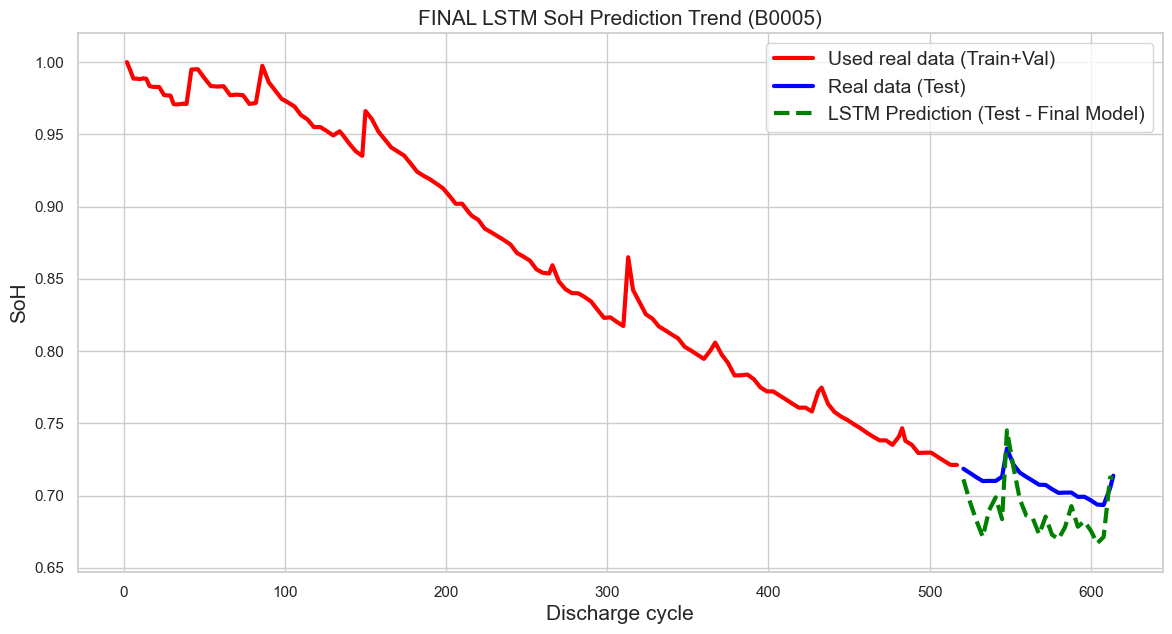

 Saved final model to ../models/lstm_final_B0005_soh.keras
 Saved scaler to ../models/scaler_lstm_B0005_soh.pkl
--- Finished processing B0005 in 13.56 seconds ---

--- Processing Battery: B0006 ---
 Loaded nasa_battery_data_B0006_preprocessed.csv. Shape: (591458, 18)
 Splitting data...
 Preparing sequences...
 Scaling features...
 Padding sequences...
 Padded to max length: 371

 Initial LSTM model built.


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Initial_B0006"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 371, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

 Initial training...
 Initial training stopped at epoch: 19
 Loaded best weights from initial training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
 Initial Validation R2: 0.9368

 Re-training final LSTM model on combined Train + Validation data...
 Training final model for 20 epochs...


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Final model training complete.
 Evaluating final LSTM on Test Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
  FINAL Test MAE (LSTM):  0.0405
  FINAL Test RMSE (LSTM): 0.0432
  FINAL Test R2 (LSTM):   -3.9514
 Plotting final trend comparison...


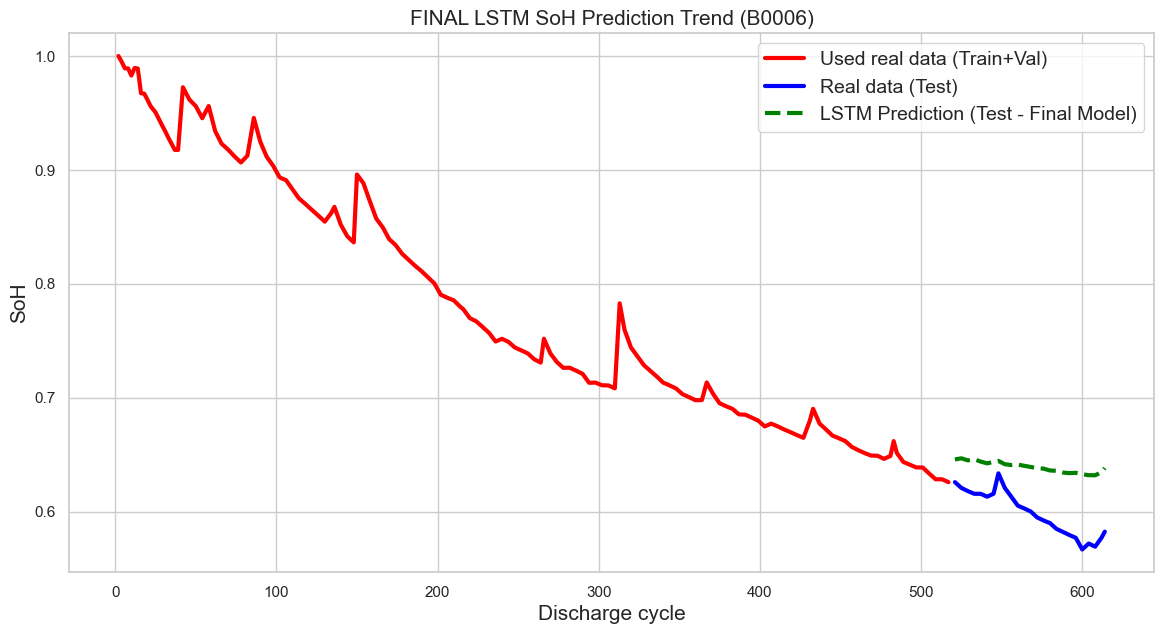

 Saved final model to ../models/lstm_final_B0006_soh.keras
 Saved scaler to ../models/scaler_lstm_B0006_soh.pkl
--- Finished processing B0006 in 13.11 seconds ---

--- Processing Battery: B0018 ---
 Loaded nasa_battery_data_B0018_preprocessed.csv. Shape: (314674, 18)
 Splitting data...
 Preparing sequences...
 Scaling features...
 Padding sequences...
 Padded to max length: 366

 Initial LSTM model built.


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Initial_B0018"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)             │ (None, 366, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

 Initial training...
 Initial training stopped at epoch: 31
 Loaded best weights from initial training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
 Initial Validation R2: 0.6593

 Re-training final LSTM model on combined Train + Validation data...
 Training final model for 20 epochs...


/Users/dolphinium/anaconda3/envs/nasa/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Final model training complete.
 Evaluating final LSTM on Test Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
  FINAL Test MAE (LSTM):  0.0154
  FINAL Test RMSE (LSTM): 0.0174
  FINAL Test R2 (LSTM):   -1.3794
 Plotting final trend comparison...


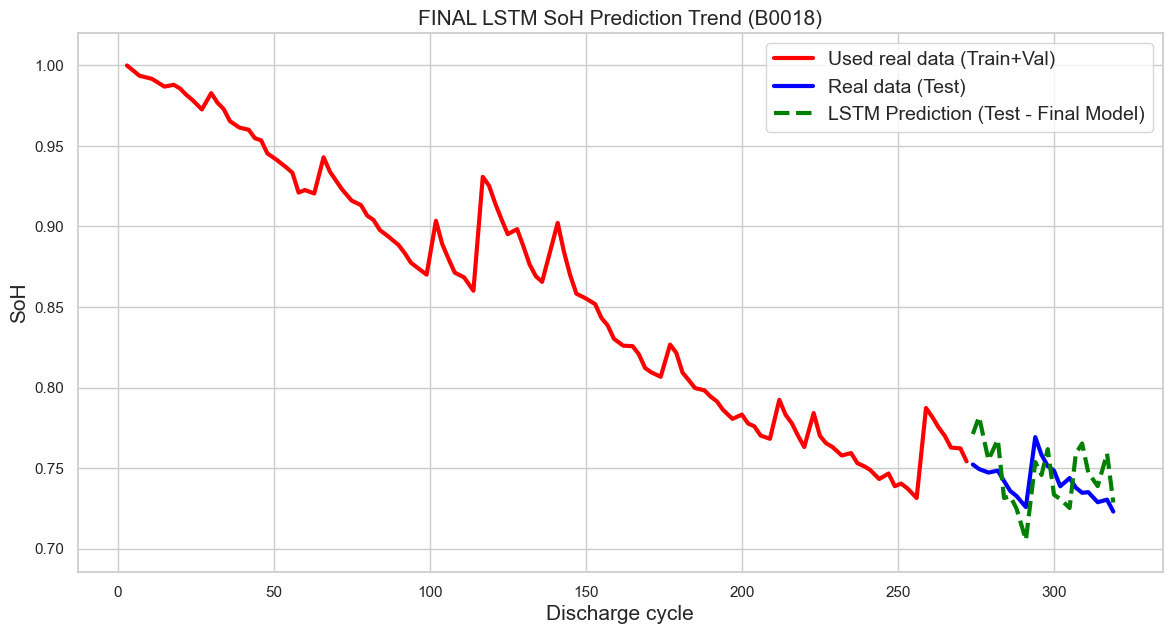

 Saved final model to ../models/lstm_final_B0018_soh.keras
 Saved scaler to ../models/scaler_lstm_B0018_soh.pkl
--- Finished processing B0018 in 13.01 seconds ---

--- Final Test Results Summary ---


,mae,rmse,r2
B0005,0.020466,0.022701,-5.542615
B0006,0.040478,0.043167,-3.951355
B0018,0.015439,0.017422,-1.379352


In [15]:
# --- Define Sequence Features ---
sequence_features_to_use = [
    'voltage_measured_smooth',
    'current_measured_smooth',
    'temperature_measured_smooth',
    'measurement_time_relative'
]

# --- Run for Other Batteries ---
batteries_to_run = ['B0005','B0006', 'B0018'] # Add B0005 if you want to rerun it with the function
all_results = {}

for bat_id in batteries_to_run:
    # Call the function with appropriate paths
    results = train_evaluate_lstm_soh(
        battery_id=bat_id,
        data_dir=PROCESSED_DATA_DIR,
        model_dir=MODEL_DIR,
        viz_dir=VISUALIZATION_DIR,
        sequence_features=sequence_features_to_use
        # Add other parameters like epochs if you want to override defaults
    )
    all_results[bat_id] = results

# --- Display Results ---
print("\n--- Final Test Results Summary ---")
results_df = pd.DataFrame.from_dict(all_results, orient='index')
display(results_df)